# Spaceship Titanic Analysis

the goal of this project is to predict whether passengers aboard the Spaceship Titanic were transported to another dimension during a galactic anomaly, based on various behavioral, demographic, and activity-related features.

In [41]:
import warnings

import numpy as np
import pandas as pd
import optuna
import shap
import phik

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson, chi2_contingency, mannwhitneyu
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from custom_preprocessor import CustomPreprocessor
from outliers_function import outliers
from spending_function import encode_spending
from binary_mapping import map_binary_columns
from missing_values import num_imputation
from missing_cabin import process_cabin
from missing_categor import fill_categorical_missing
from extracting_features import extract_group_features
from ci_proportion import calculate_ci_for_proportion
from ci_mean import calculate_ci_for_mean

In [42]:
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

## Data Overview

In [43]:
spaceship_df = pd.read_csv("train.csv")
spaceship_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


We start by loading the dataset.

In [44]:
spaceship_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


We inspect the column types and how many entries and colimns we have.

In [45]:
spaceship_df["Transported"].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

From our target variable, Transported, we can see that it has a relatively balanced distribution between the two classes. This balanced dataset, is very useful for training models, as it reduces the risk of class imbalance issues.

In [46]:
spaceship_df["HomePlanet"].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

In [47]:
home_planet_crosstab = pd.crosstab(
    spaceship_df["HomePlanet"], spaceship_df["Transported"]
)
home_planet_crosstab

Transported,False,True
HomePlanet,,
Earth,2651,1951
Europa,727,1404
Mars,839,920


In [48]:
spaceship_df["Destination"].value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [49]:
spaceship_df["CryoSleep"].value_counts()

CryoSleep
False    5439
True     3037
Name: count, dtype: int64

In [50]:
cryo_sleep_crosstab = pd.crosstab(
    spaceship_df["CryoSleep"], spaceship_df["Transported"]
)
cryo_sleep_crosstab

Transported,False,True
CryoSleep,,
False,3650,1789
True,554,2483


A quick overview of the dataset reveals that HomePlanet, CryoSleep, and Destination are key predictors of the target variable, Transported, with passengers from Earth and those using CryoSleep more likely to be transported. There is some feature imbalance, particularly with CryoSleep and Destination, but these features remain valuable for model training.

In [51]:
spaceship_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


The dataset shows high variance in features like Age, RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck, with many zero values indicating underuse of services. Some features, like RoomService and FoodCourt, have outliers where passengers spent unusually large amounts, while Age has a more balanced distribution around 28 years.

## Train-Test Split

In [52]:
X = spaceship_df.drop(columns=["Transported"])
y = spaceship_df["Transported"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)

print("Train set class distribution:")
print(y_train.value_counts(normalize=True) * 100)
print(y_train.value_counts())

print("\nValidation set class distribution:")
print(y_val.value_counts(normalize=True) * 100)
print(y_val.value_counts())

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True) * 100)
print(y_test.value_counts())

Train set class distribution:
Transported
True     50.354746
False    49.645254
Name: proportion, dtype: float64
Transported
True     2626
False    2589
Name: count, dtype: int64

Validation set class distribution:
Transported
True     50.373778
False    49.626222
Name: proportion, dtype: float64
Transported
True     876
False    863
Name: count, dtype: int64

Test set class distribution:
Transported
True     50.373778
False    49.626222
Name: proportion, dtype: float64
Transported
True     876
False    863
Name: count, dtype: int64


The data was split into training, validation, and test sets using stratified sampling to preserve class balance. Each split maintains an almost perfect 50/50 distribution between the Transported classes, ensuring fair and unbiased model evaluation across all subsets.

## Exploratory Data Analysis

In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5215 entries, 3511 to 4417
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   5215 non-null   object 
 1   HomePlanet    5091 non-null   object 
 2   CryoSleep     5082 non-null   object 
 3   Cabin         5090 non-null   object 
 4   Destination   5098 non-null   object 
 5   Age           5107 non-null   float64
 6   VIP           5092 non-null   object 
 7   RoomService   5111 non-null   float64
 8   FoodCourt     5099 non-null   float64
 9   ShoppingMall  5088 non-null   float64
 10  Spa           5102 non-null   float64
 11  VRDeck        5106 non-null   float64
 12  Name          5098 non-null   object 
dtypes: float64(6), object(7)
memory usage: 570.4+ KB


In [54]:
duplicates = X_train.duplicated().sum()
duplicates

0

There were no duplicates.

In [55]:
X_train.isnull().sum()

PassengerId       0
HomePlanet      124
CryoSleep       133
Cabin           125
Destination     117
Age             108
VIP             123
RoomService     104
FoodCourt       116
ShoppingMall    127
Spa             113
VRDeck          109
Name            117
dtype: int64

There were missing valiues in every column.

In [56]:
missing_data = X_train[X_train.isnull().any(axis=1)]
missing_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
3511,3772_02,Earth,False,F/777/P,TRAPPIST-1e,20.0,False,0.0,NaN,422.0,0.0,0.0,Tany Castron
8534,9112_01,Mars,False,D/290/P,TRAPPIST-1e,28.0,False,NaN,0.0,0.0,0.0,0.0,Wealke Brin
3809,4068_01,Europa,False,D/131/S,TRAPPIST-1e,27.0,False,NaN,1381.0,0.0,148.0,2181.0,Dnocese Pirejus
2454,2633_01,Earth,False,G/428/P,55 Cancri e,26.0,False,0.0,0.0,0.0,0.0,NaN,Herina Popez
6467,6825_02,Mars,False,F/1306/S,TRAPPIST-1e,24.0,False,3481.0,0.0,1236.0,2.0,256.0,NaN


In [57]:
missing_name_rows = X_train[X_train["Name"].isnull()]
missing_name_rows.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
6467,6825_02,Mars,False,F/1306/S,TRAPPIST-1e,24.0,False,3481.0,0.0,1236.0,2.0,256.0,NaN
4082,4359_01,Europa,False,C/137/P,TRAPPIST-1e,28.0,False,3.0,2127.0,0.0,696.0,10.0,NaN
4674,4980_03,Earth,False,G/805/P,TRAPPIST-1e,11.0,False,0.0,0.0,0.0,0.0,0.0,NaN
4548,4840_01,NaN,True,F/915/S,TRAPPIST-1e,36.0,False,0.0,0.0,NaN,0.0,0.0,NaN
7854,8382_01,Europa,False,C/277/P,TRAPPIST-1e,43.0,False,0.0,7269.0,0.0,2750.0,2367.0,NaN


### Data Distribution Visualization

#### Bar Plots for Categorical Variables

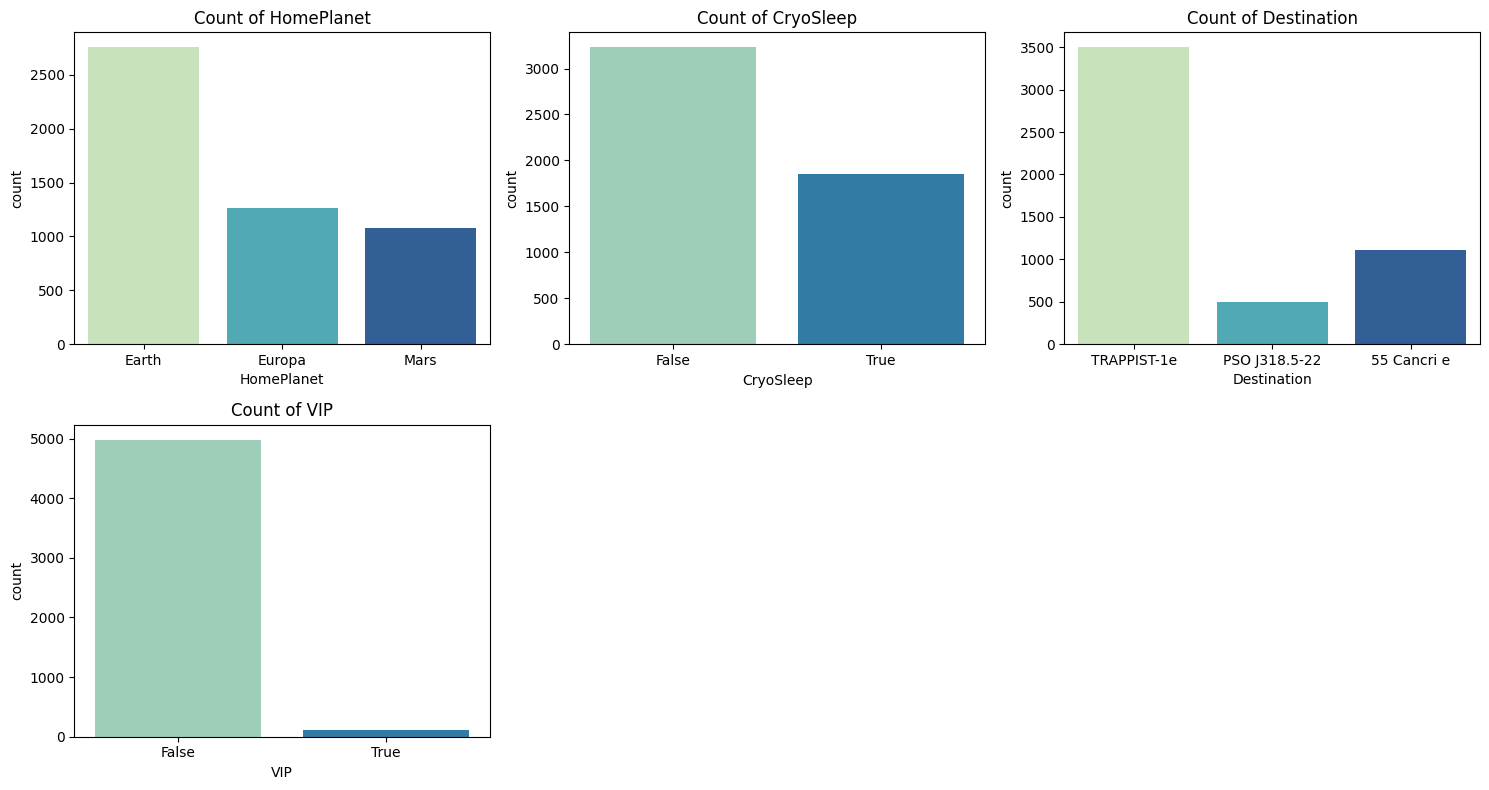

In [58]:
cat_features = [
    "HomePlanet",
    "CryoSleep",
    "Destination",
    "VIP",
]

plt.figure(figsize=(15, 8))
for i, col in enumerate(cat_features):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=X_train[col], hue=X_train[col], palette="YlGnBu", legend=False)
    plt.title(f"Count of {col}")
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The categorical feature distributions show that most passengers originated from Earth (2,756), followed by Europa (1,261) and Mars (1,074), with 124 missing values for HomePlanet. The majority of passengers were not in CryoSleep (3,232), while 1,850 were, and 133 entries are missing. Regarding destination, the most common destination by far was TRAPPIST-1e (3,500), with 55 Cancri e (1,105) and PSO J318.5-22 (493) being less frequent; 117 destination entries are missing. For the VIP status, the vast majority of passengers were not VIPs (4,981), while only 111 were, and 123 values are missing. These distributions highlight class imbalances and indicate the presence of missing values that may affect model training and require preprocessing.

#### Correlation Matrix (Numerical Features Only)

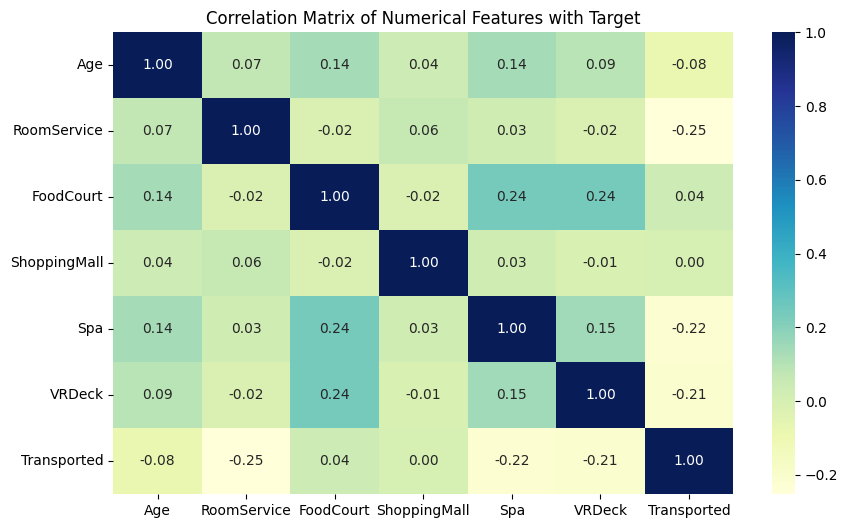

In [59]:
plt.figure(figsize=(10, 6))
numeric_features = X_train.select_dtypes(include=["number"])
df_with_target = numeric_features.copy()
df_with_target["Transported"] = y_train

sns.heatmap(df_with_target.corr(), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features with Target")
plt.show()

Pearson correlation analysis between numerical features and the target (Transported) reveals relatively weak linear relationships. Among all numerical features, RoomService (-0.25), Spa (-0.22), and VRDeck (-0.21) show the strongest (albeit still modest) negative correlations with being transported, suggesting that passengers who spent less on these services were more likely to be transported. Age shows a very weak negative correlation (-0.08), implying only a minimal relationship with the outcome. In contrast, FoodCourt (0.04) and ShoppingMall (0.0005) show negligible positive correlations. Overall, these findings indicate that while some spending-related features may have slight influence, no numerical variable alone has a strong linear relationship with the transport outcome, supporting the use of complex models that can capture nonlinear patterns.

In [60]:
correlation_with_target = df_with_target.corr()["Transported"].sort_values(
    ascending=False
)

correlation_df = correlation_with_target.reset_index()
correlation_df.columns = ["Feature", "Correlation with Transported"]
print(correlation_df)

        Feature  Correlation with Transported
0   Transported                      1.000000
1     FoodCourt                      0.039744
2  ShoppingMall                      0.000537
3           Age                     -0.081525
4        VRDeck                     -0.205230
5           Spa                     -0.220687
6   RoomService                     -0.252721


#### Categorical Features vs Transported

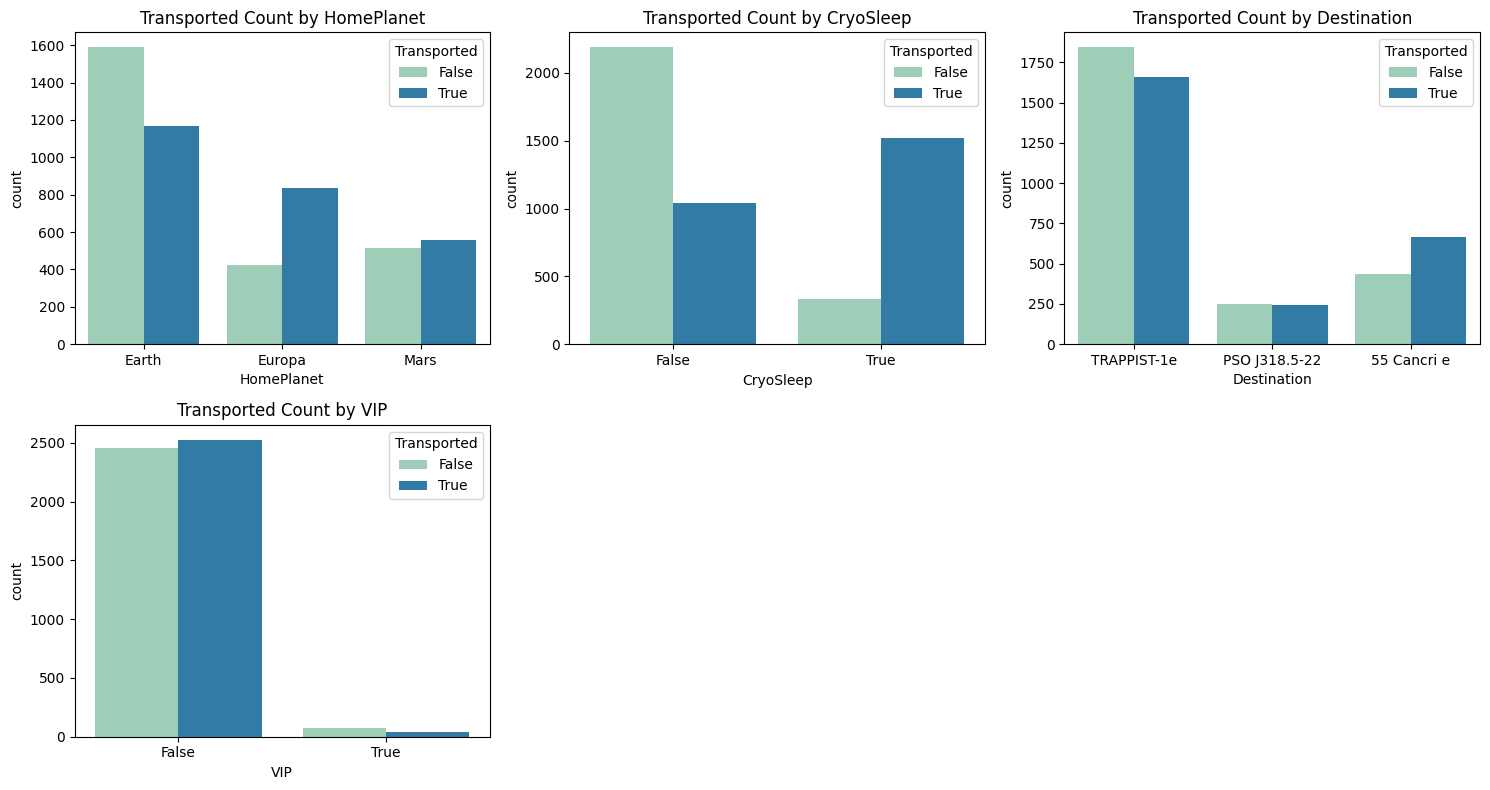

In [61]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(cat_features):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=X_train[col], hue=y_train, palette="YlGnBu")
    plt.title(f"Transported Count by {col}")
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The distribution of categorical features in relation to the target variable reveals several key patterns. CryoSleep status is a strong indicator of being transported—passengers in CryoSleep were much more likely to be transported compared to those who were not. HomePlanet also plays a role: passengers from Europa had a higher transport rate, while those from Earth were less likely to be transported. Destination influences the outcome as well, with 55 Cancri e showing a higher proportion of transported passengers. In contrast, VIP status appears to have minimal predictive power, as both VIP and non-VIP passengers show fairly balanced transport outcomes. Overall, behavioral and origin-related features are more informative than social status in predicting transport likelihood.

#### Hist Plots for Numerical Variables

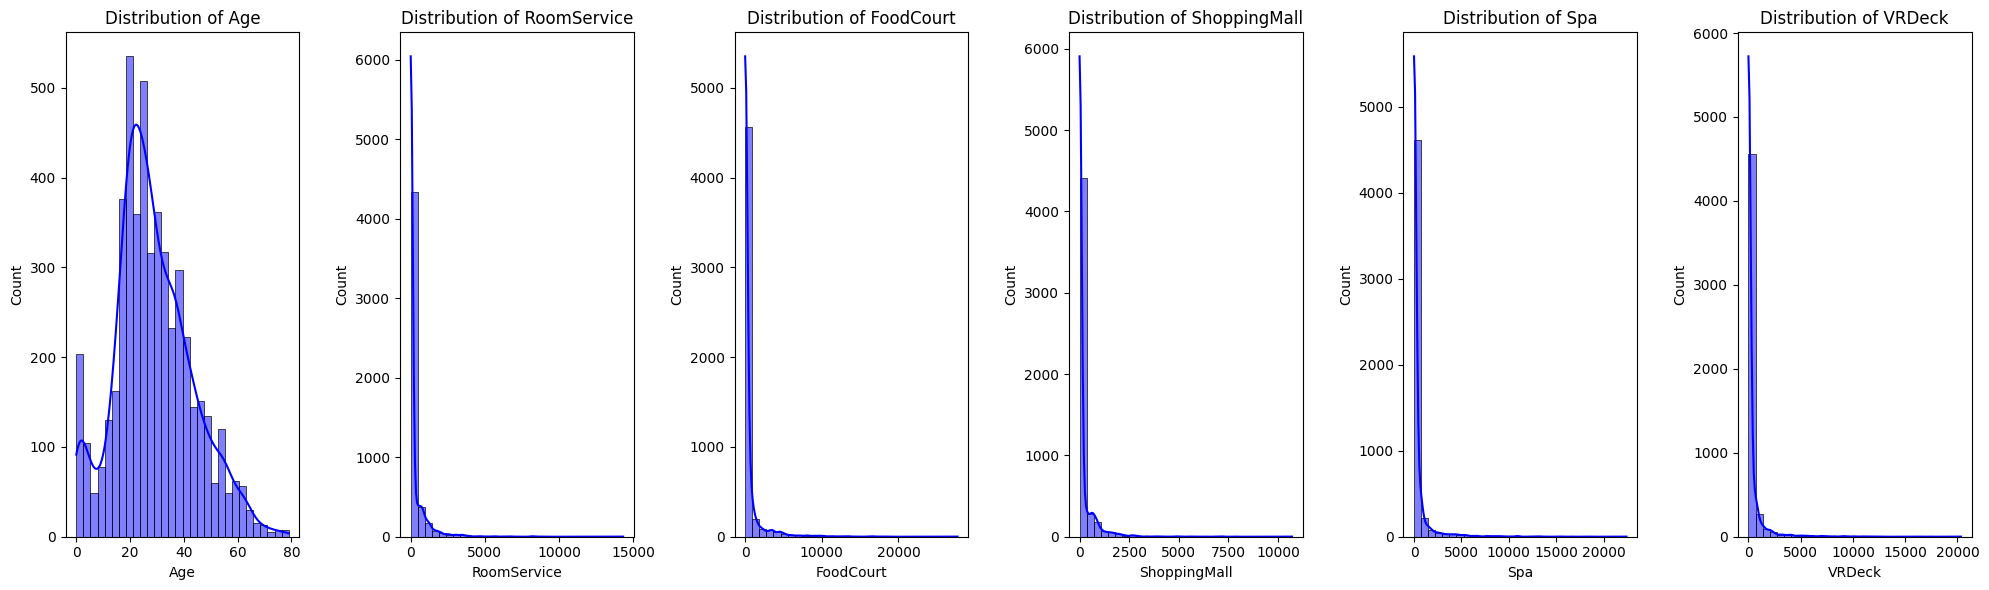

In [62]:
num_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

plt.figure(figsize=(20, 6))
for i, col in enumerate(num_cols):
    plt.subplot(1, 6, i + 1)
    sns.histplot(X_train[col], bins=30, kde=True, color="blue", palette="YlGnBu")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

The summary statistics of key numerical features reveal notable patterns in passenger behavior. Age is fairly normally distributed, with a mean of 28.75 and most passengers falling between 20 and 37 years old. In contrast, spending-related features such as RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck are highly skewed—most passengers spend nothing, while a smaller portion incurs very high expenses. This is evident from their median values being zero and extremely large maximums (e.g., Spa: 22,408, FoodCourt: 27,723). The wide spread and high standard deviations across these features indicate diverse spending habits, suggesting that discretionary service usage varies significantly among passengers and likely plays an important role in predicting outcomes.

### Outliers

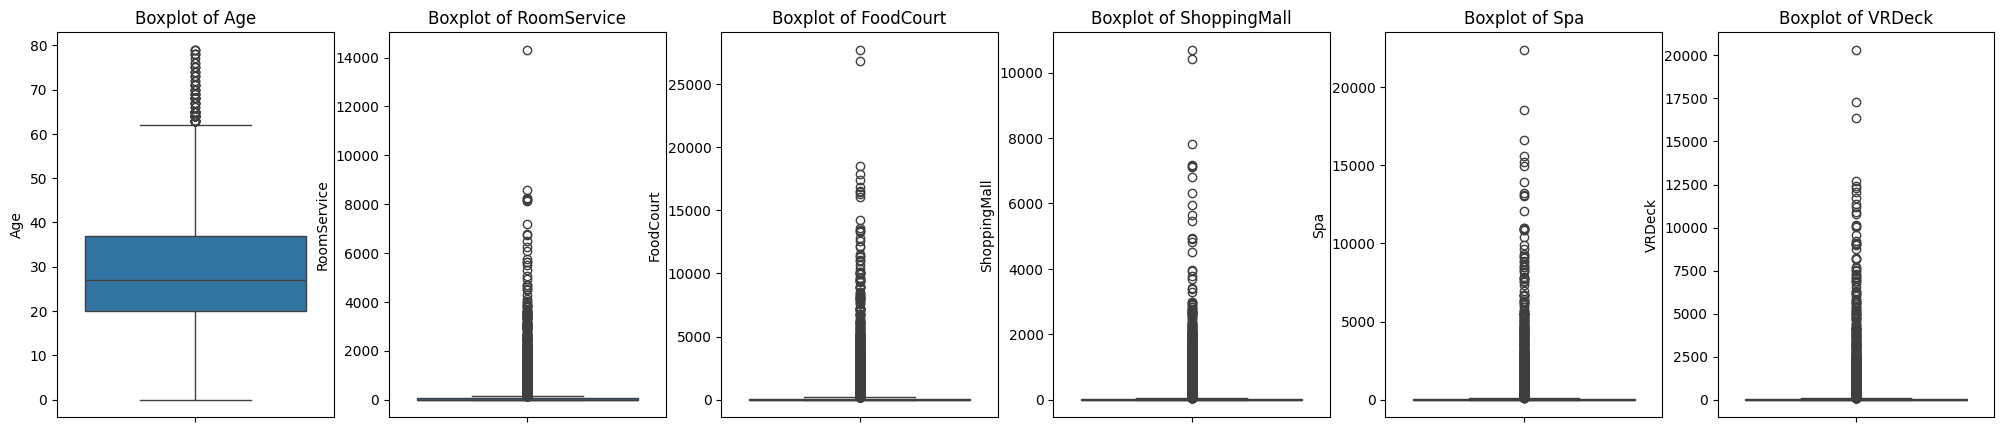

In [63]:
num_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
plt.figure(figsize=(25, 5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 6, i)
    sns.boxplot(y=X_train[col])
    plt.title(f"Boxplot of {col}")
plt.show()

In [64]:
X_train["outlier_Age"] = outliers(X_train, "Age")
X_train["outlier_RoomService"] = outliers(X_train, "RoomService")
X_train["outlier_FoodCourt"] = outliers(X_train, "FoodCourt")
X_train["outlier_ShoppingMall"] = outliers(X_train, "ShoppingMall")
X_train["outlier_Spa"] = outliers(X_train, "Spa")
X_train["outlier_VRDeck"] = outliers(X_train, "VRDeck")

print("Outliers in Age:", X_train["outlier_Age"].sum())
print("Outliers in RoomService:", X_train["outlier_RoomService"].sum())
print("Outliers in FoodCourt:", X_train["outlier_FoodCourt"].sum())
print("Outliers in ShoppingMall:", X_train["outlier_ShoppingMall"].sum())
print("Outliers in Spa:", X_train["outlier_Spa"].sum())
print("Outliers in VRDeck:", X_train["outlier_VRDeck"].sum())

Outliers in Age: 97
Outliers in RoomService: 1102
Outliers in FoodCourt: 1097
Outliers in ShoppingMall: 1104
Outliers in Spa: 1071
Outliers in VRDeck: 1084


Outlier detection using the IQR method revealed a significant number of extreme values in service-related features like RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck—each with over 1,000 outliers. In contrast, Age had relatively few outliers (97), indicating a more consistent distribution. This suggests that service features are heavily skewed, possibly due to a subset of passengers spending abnormally high amounts. in order not to luse valuable data we will encode spending amenitie, however we will leave age as is because there are not as many or extream outliers as in spending amenities.

In [65]:
X_train.drop(
    columns=[
        "outlier_Age",
        "outlier_RoomService",
        "outlier_FoodCourt",
        "outlier_ShoppingMall",
        "outlier_Spa",
        "outlier_VRDeck",
    ],
    inplace=True,
)

After evaluating outliers we drop outlier columns.

### Encoding spending amenities

In [66]:
spending_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
X_train = encode_spending(X_train, spending_columns)
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,RoomService_cat,FoodCourt_cat,ShoppingMall_cat,Spa_cat,VRDeck_cat
3511,3772_02,Earth,False,F/777/P,TRAPPIST-1e,20.0,False,0.0,NaN,422.0,0.0,0.0,Tany Castron,0,0,1,0,0
7255,7757_01,Europa,True,B/300/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,Muonons Lowerrudy,0,0,0,0,0
8534,9112_01,Mars,False,D/290/P,TRAPPIST-1e,28.0,False,NaN,0.0,0.0,0.0,0.0,Wealke Brin,0,0,0,0,0
419,0454_03,Europa,True,B/15/S,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,Hallux Geoconne,0,0,0,0,0
4752,5069_01,Earth,False,F/965/S,PSO J318.5-22,56.0,False,1309.0,0.0,69.0,1.0,0.0,Andary Hurchez,1,0,1,1,0


The encode_spending function creates binary features that indicate whether a passenger used a particular service (1 if spent more than 0, otherwise 0). This transformation simplifies high-variance spending data into meaningful usage indicators. As seen in the output, new columns like RoomService_cat, Spa_cat and ShoppingMall_cat clearly flag service usage, helping models capture behavioral patterns without being influenced by outlier spending amounts.

### Encoding binary columns

In [67]:
X_train = map_binary_columns(X_train)
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,RoomService_cat,FoodCourt_cat,ShoppingMall_cat,Spa_cat,VRDeck_cat
3511,3772_02,Earth,0,F/777/P,TRAPPIST-1e,20.0,0,0.0,NaN,422.0,0.0,0.0,Tany Castron,0,0,1,0,0
7255,7757_01,Europa,1,B/300/S,TRAPPIST-1e,28.0,0,0.0,0.0,0.0,0.0,0.0,Muonons Lowerrudy,0,0,0,0,0
8534,9112_01,Mars,0,D/290/P,TRAPPIST-1e,28.0,0,NaN,0.0,0.0,0.0,0.0,Wealke Brin,0,0,0,0,0
419,0454_03,Europa,1,B/15/S,TRAPPIST-1e,43.0,0,0.0,0.0,0.0,0.0,0.0,Hallux Geoconne,0,0,0,0,0
4752,5069_01,Earth,0,F/965/S,PSO J318.5-22,56.0,0,1309.0,0.0,69.0,1.0,0.0,Andary Hurchez,1,0,1,1,0


This function converts the binary categorical columns CryoSleep and VIP into numeric format (0/1), making them model-ready. Missing values are filled with 0, assuming the default to be "False". This step ensures consistent and clean input for modeling by removing non-numeric and missing entries from critical boolean features.

In [68]:
X_train["CryoSleep"].value_counts()

CryoSleep
0    3365
1    1850
Name: count, dtype: int64

In [69]:
X_train["VIP"].value_counts()

VIP
0    5104
1     111
Name: count, dtype: int64

### Cleaning missing values

In [70]:
X_train = num_imputation(X_train)
X_train = process_cabin(X_train)
X_train = fill_categorical_missing(X_train, ["HomePlanet", "Destination"])
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,RoomService_cat,FoodCourt_cat,ShoppingMall_cat,Spa_cat,VRDeck_cat,Deck,Number,Side
3511,3772_02,Earth,0,TRAPPIST-1e,20.0,0,0.0,NaN,422.0,0.0,0.0,Tany Castron,0,0,1,0,0,F,777,P
7255,7757_01,Europa,1,TRAPPIST-1e,28.0,0,0.0,0.0,0.0,0.0,0.0,Muonons Lowerrudy,0,0,0,0,0,B,300,S
8534,9112_01,Mars,0,TRAPPIST-1e,28.0,0,NaN,0.0,0.0,0.0,0.0,Wealke Brin,0,0,0,0,0,D,290,P
419,0454_03,Europa,1,TRAPPIST-1e,43.0,0,0.0,0.0,0.0,0.0,0.0,Hallux Geoconne,0,0,0,0,0,B,15,S
4752,5069_01,Earth,0,PSO J318.5-22,56.0,0,1309.0,0.0,69.0,1.0,0.0,Andary Hurchez,1,0,1,1,0,F,965,S


These three functions handles missing data and prepares key features for modeling. It fills missing Age values with the median, extracts meaningful parts (Deck, Number, Side) from the Cabin column, and replaces missing categorical values in HomePlanet and Destination with "Unknown". These steps ensure a cleaner, more consistent dataset, enabling better model performance.

## Feature engineering

In [71]:
X_train = extract_group_features(X_train)
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,ShoppingMall_cat,Spa_cat,VRDeck_cat,Deck,Number,Side,GroupID,GroupSize,FamilySize,IsSolo
3511,3772_02,Earth,0,TRAPPIST-1e,20.0,0,0.0,NaN,422.0,0.0,...,1,0,0,F,777,P,3772,1,4,0
7255,7757_01,Europa,1,TRAPPIST-1e,28.0,0,0.0,0.0,0.0,0.0,...,0,0,0,B,300,S,7757,2,2,0
8534,9112_01,Mars,0,TRAPPIST-1e,28.0,0,NaN,0.0,0.0,0.0,...,0,0,0,D,290,P,9112,1,3,0
419,0454_03,Europa,1,TRAPPIST-1e,43.0,0,0.0,0.0,0.0,0.0,...,0,0,0,B,15,S,0454,2,1,1
4752,5069_01,Earth,0,PSO J318.5-22,56.0,0,1309.0,0.0,69.0,1.0,...,1,1,0,F,965,S,5069,1,7,0


This function enriches the dataset by creating group-based features. It derives GroupID from PassengerId and uses both GroupID and passenger Name to compute group size (GroupSize), family size (FamilySize), and whether the passenger is traveling alone (IsSolo). These features help capture social or group travel patterns, which could be valuable for predicting transport outcomes.

In [72]:
X_train["FamilySize"].value_counts()

FamilySize
3     1141
2     1043
4      922
1      682
5      662
6      306
7      211
8      128
9       99
11      11
10      10
Name: count, dtype: int64

In [73]:
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns
corr_with_target = (
    X_train[numerical_cols].corrwith(y_train).sort_values(ascending=False)
)
print(corr_with_target)

GroupSize       0.075860
FoodCourt       0.039744
ShoppingMall    0.000537
Number         -0.051788
Age            -0.080599
VRDeck         -0.205230
Spa            -0.220687
RoomService    -0.252721
dtype: float64


Correlation analysis shows that most numerical features have weak relationships with the target variable. RoomService, Spa, and VRDeck have the strongest (negative) correlations, while GroupSize shows a slight positive correlation. Overall, these features may offer some predictive value but are not individually strong indicators.

In [74]:
X_train["ServiceCount"] = X_train[
    ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
].sum(axis=1)

In [75]:
X_train["UsedAnyService"] = (
    X_train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
    > 0
).astype(int)

Two new features were added: ServiceCount, which sums all service expenses, and UsedAnyService, which indicates whether a passenger used at least one service. These features help capture overall service usage behavior in a simple, informative way.

In [76]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5215 entries, 3511 to 4417
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       5215 non-null   object 
 1   HomePlanet        5215 non-null   object 
 2   CryoSleep         5215 non-null   int32  
 3   Destination       5215 non-null   object 
 4   Age               5215 non-null   float64
 5   VIP               5215 non-null   int32  
 6   RoomService       5111 non-null   float64
 7   FoodCourt         5099 non-null   float64
 8   ShoppingMall      5088 non-null   float64
 9   Spa               5102 non-null   float64
 10  VRDeck            5106 non-null   float64
 11  RoomService_cat   5215 non-null   int32  
 12  FoodCourt_cat     5215 non-null   int32  
 13  ShoppingMall_cat  5215 non-null   int32  
 14  Spa_cat           5215 non-null   int32  
 15  VRDeck_cat        5215 non-null   int32  
 16  Deck              5215 non-null   object 
 1

### Feature correlation

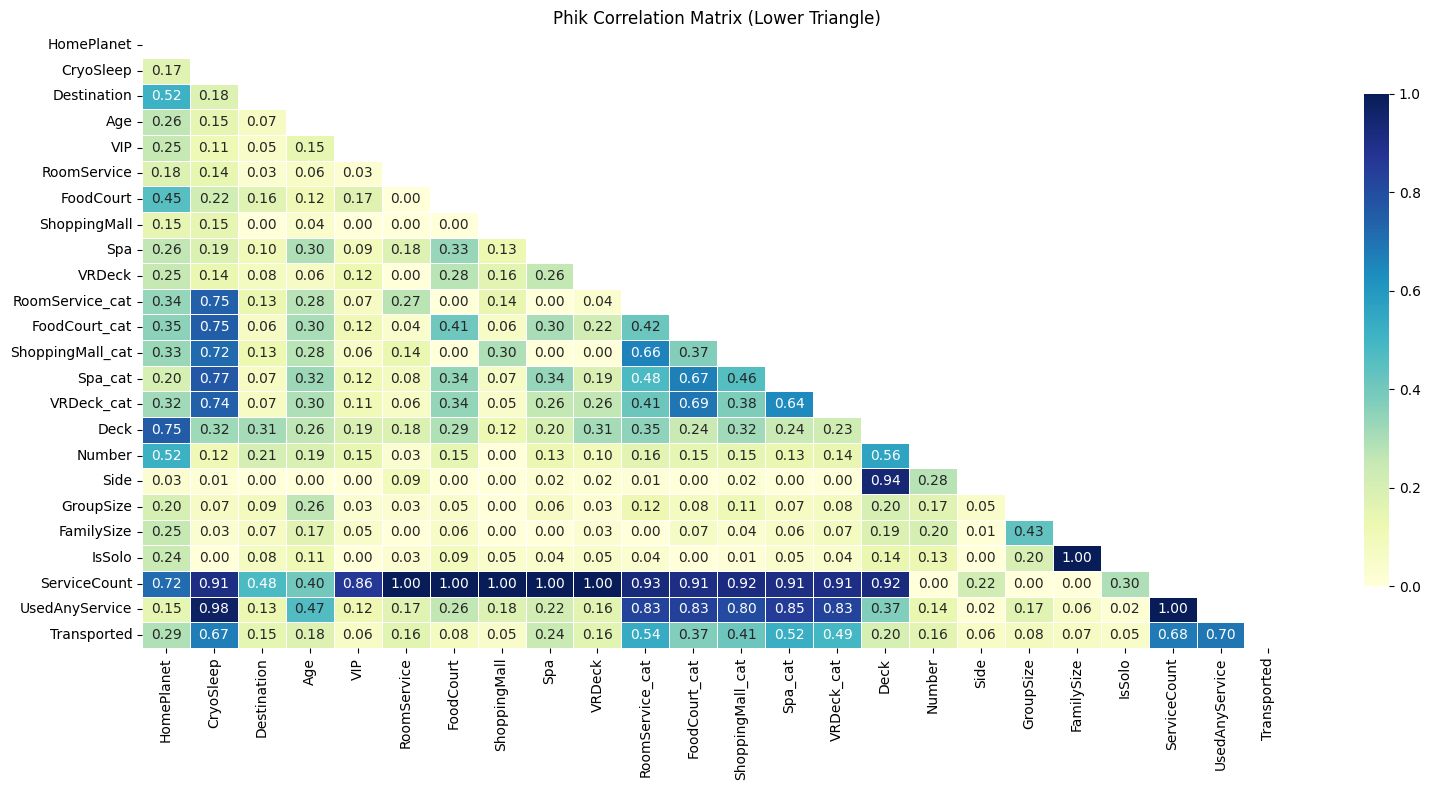

In [77]:
df_phik = X_train.copy()
df_phik["Transported"] = y_train

exclude_cols = ["PassengerId", "GroupID"]
cols_for_phik = [col for col in df_phik.columns if col not in exclude_cols]
X_temp = df_phik[cols_for_phik]

interval_cols = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "Number",
    "GroupSize",
    "FamilySize",
]

phik_matrix = X_temp.phik_matrix(interval_cols=interval_cols)
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(16, 8))
sns.heatmap(
    phik_matrix,
    mask=mask,
    cmap="YlGnBu",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Phik Correlation Matrix (Lower Triangle)")
plt.tight_layout()
plt.show()

The PhiK correlation analysis shows that UsedAnyService, ServiceCount, and CryoSleep are the most strongly associated with the target variable Transported, making them highly valuable for prediction. Categorical indicators like RoomService_cat and Spa_cat are more informative than raw spending amounts, suggesting that simply using a service matters more than how much was spent. Features like HomePlanet, Deck, and Age show moderate relevance, while others such as VIP, Side, and IsSolo have very weak correlations and may add little predictive value on their own. Overall, the analysis helps prioritize the most impactful features for modeling.

## Statistical Inference

### Defining Target Population

Based on this dataset the target population are passengers aboard Spaceship Titanic which either were transported or not to the alternate dimension after the collision with the spacetime anomaly. The population consists of passengers from various planets, age groups, service statuses and such. The objective is to build a predictive model based on this dataset and predict which passengers were transported during this event.

### Multiple Statistical Hypotheses

1. Hypothesis for Amenities Spend (Spa, RoomService, VRDeck, ShoppingMall, FoodCourt)
- Null Hypothesis (H₀): There is no significant relationship between the amount a passenger spends on luxury amenities (Spa, RoomService, VRDeck, ShoppingMall, FoodCourt) and whether they were transported.
- Alternative Hypothesis (H₁): There is a significant relationship between the amount a passenger spends on luxury amenities (Spa, RoomService, VRDeck, ShoppingMall, FoodCourt) and whether they were transported.

2. Hypothesis for CryoSleep
- Null Hypothesis (H₀): The likelihood of a passenger being transported is the same regardless of whether they are in CryoSleep.
- Alternative Hypothesis (H₁): Passengers in CryoSleep have a different likelihood of being transported compared to those who are not in CryoSleep.

3. Hypothesis for HomePlanet
- Null Hypothesis (H₀): There is no significant difference in the likelihood of being transported based on a passenger's HomePlanet.
- Alternative Hypothesis (H₁): The likelihood of being transported differs significantly based on a passenger's HomePlanet.

4. Hypothesis for GroupSize and FamilySize
- Null Hypothesis (H₀): The likelihood of a passenger being transported is not affected by their group or family size.
- Alternative Hypothesis (H₁): The likelihood of a passenger being transported is affected by their group or family size.

5. Hypothesis for VIP Status
- Null Hypothesis (H₀): VIP passengers have the same likelihood of being transported as non-VIP passengers.
- Alternative Hypothesis (H₁): VIP passengers have a different likelihood of being transported compared to non-VIP passengers.

6. Hypothesis for Age
- Null Hypothesis (H₀): Age has no effect on the likelihood of being transported.
- Alternative Hypothesis (H₁): Age affects the likelihood of being transported.

7. Hypothesis for Deck, Number, and Side (Derived from Cabin)
- Null Hypothesis (H₀): The location of the passenger (Deck, Number, Side) has no effect on the likelihood of being transported.
- Alternative Hypothesis (H₁): The location of the passenger (Deck, Number, Side) affects the likelihood of being transported.

8. Hypothesis for IsSolo
- Null Hypothesis (H₀): Being alone (IsSolo) has no effect on the likelihood of being transported.
- Alternative Hypothesis (H₁): Being alone (IsSolo) affects the likelihood of being transported.

9. Hypothesis for Destination
- Null Hypothesis (H₀): The destination planet has no effect on the likelihood of being transported.
- Alternative Hypothesis (H₁): The destination planet affects the likelihood of being transported.

### Setting Significance Levels

Significance Level and Hypothesis Testing:
- We chose a significance level (α) = 0.05 for our hypothesis tests, which corresponds to a 95% confidence level.
- Null Hypothesis (H₀): There is no effect or relationship (e.g., no difference in stroke rates across work types). 
- Alternative Hypothesis (H₁): There is an effect or relationship (e.g., there is a difference in stroke rates across work types).

Decision Rule:
- If the p-value < 0.05: Reject the null hypothesis (H₀), indicating a statistically significant effect.
- If the p-value ≥ 0.05: Fail to reject the null hypothesis (H₀), indicating no statistically significant effect.

Confidence Intervals:
- We used 95% confidence intervals (CI) to estimate the range within which the true population parameter (proportion) lies with 95% certainty.
- If the confidence interval does not include the null value (e.g., zero for differences or one for ratios), it supports rejecting the null hypothesis.

### Conducting Statistical Tests

In [78]:
features_to_check = [
    "Age",
    "Spa",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "VRDeck",
    "Number",
    "GroupSize",
    "FamilySize",
]

for feature in features_to_check:
    result = anderson(X_train[feature])
    stat = result.statistic
    critical_val = result.critical_values[2]
    print(
        f"{feature}: Statistic={stat:.3f}, Critical at 5% = {critical_val:.3f} ->",
        "Not Normal" if stat > critical_val else "Normal",
    )

Age: Statistic=33.719, Critical at 5% = 0.786 -> Not Normal
Spa: Statistic=nan, Critical at 5% = 0.786 -> Normal
RoomService: Statistic=nan, Critical at 5% = 0.786 -> Normal
FoodCourt: Statistic=nan, Critical at 5% = 0.786 -> Normal
ShoppingMall: Statistic=nan, Critical at 5% = 0.786 -> Normal
VRDeck: Statistic=nan, Critical at 5% = 0.786 -> Normal
Number: Statistic=197.202, Critical at 5% = 0.786 -> Not Normal
GroupSize: Statistic=763.190, Critical at 5% = 0.786 -> Not Normal
FamilySize: Statistic=121.556, Critical at 5% = 0.786 -> Not Normal


Here we use the Anderson-Darling test to check if selected numerical features follow a normal distribution. Results show that Age, Number, GroupSize, and FamilySize are not normally distributed, indicating skewness or discreteness. Other features like Spa, RoomService, etc., returned NaN due to many zero or constant values, making normality undefined. This suggests that several features may require transformation or non-parametric methods for modeling and conducting hypothesis testing.

In [79]:
amenities = ["Spa", "RoomService", "VRDeck", "ShoppingMall", "FoodCourt"]

for feature in amenities:
    contingency_table = pd.crosstab(X_train[feature], y_train)
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(
        f"{feature} -> p-value: {p_value:.4f} ->",
        (
            "Reject Null Hypothesis"
            if p_value < 0.05
            else "Fail to reject Null Hypothesis"
        ),
    )

Spa -> p-value: 0.0000 -> Reject Null Hypothesis
RoomService -> p-value: 0.0000 -> Reject Null Hypothesis
VRDeck -> p-value: 0.0000 -> Reject Null Hypothesis
ShoppingMall -> p-value: 0.0000 -> Reject Null Hypothesis
FoodCourt -> p-value: 0.0000 -> Reject Null Hypothesis


In [80]:
cryo_ct = pd.crosstab(X_train["CryoSleep"], y_train)
chi2, p, dof, _ = chi2_contingency(cryo_ct)
print(
    "CryoSleep -> p-value:",
    p,
    "->",
    "Reject Null Hypothesis" if p < 0.05 else "Fail to reject Null Hypothesis",
)

CryoSleep -> p-value: 2.5055952189293196e-251 -> Reject Null Hypothesis


In [81]:
planet_ct = pd.crosstab(X_train["HomePlanet"], y_train)
chi2, p, dof, _ = chi2_contingency(planet_ct)
print(
    "HomePlanet -> p-value:",
    p,
    "->",
    "Reject Null Hypothesis" if p < 0.05 else "Fail to reject Null Hypothesis",
)

HomePlanet -> p-value: 6.532627055306383e-43 -> Reject Null Hypothesis


In [82]:
for feature in ["GroupSize", "FamilySize"]:
    grp1 = X_train[y_train == 1][feature]
    grp0 = X_train[y_train == 0][feature]
    u_stat, p = mannwhitneyu(grp1, grp0, alternative="two-sided")
    print(
        f"{feature} -> p-value: {p:.4f} ->",
        "Reject Null Hypothesis" if p < 0.05 else "Fail to reject Null Hypothesis",
    )

GroupSize -> p-value: 0.0000 -> Reject Null Hypothesis
FamilySize -> p-value: 0.0008 -> Reject Null Hypothesis


In [83]:
vip_ct = pd.crosstab(X_train["VIP"], y_train)
chi2, p, dof, _ = chi2_contingency(vip_ct)
print(
    "VIP -> p-value:",
    p,
    "->",
    "Reject Null Hypothesis" if p < 0.05 else "Fail to reject Null Hypothesis",
)

VIP -> p-value: 0.0031378284226637326 -> Reject Null Hypothesis


In [84]:
age_transported = X_train[y_train == 1]["Age"]
age_not = X_train[y_train == 0]["Age"]
u_stat, p = mannwhitneyu(age_transported, age_not, alternative="two-sided")
print(
    "Age -> p-value:",
    p,
    "->",
    "Reject Null Hypothesis" if p < 0.05 else "Fail to reject Null Hypothesis",
)

Age -> p-value: 3.871115850318928e-08 -> Reject Null Hypothesis


In [85]:
deck_ct = pd.crosstab(X_train["Deck"], y_train)
chi2, p, _, _ = chi2_contingency(deck_ct)
print(
    "Deck -> p-value:",
    p,
    "->",
    "Reject Null Hypothesis" if p < 0.05 else "Fail to reject Null Hypothesis",
)

side_ct = pd.crosstab(X_train["Side"], y_train)
chi2, p, _, _ = chi2_contingency(side_ct)
print(
    "Side -> p-value:",
    p,
    "->",
    "Reject Null Hypothesis" if p < 0.05 else "Fail to reject Null Hypothesis",
)

num1 = X_train[y_train == 1]["Number"]
num0 = X_train[y_train == 0]["Number"]
u_stat, p = mannwhitneyu(num1, num0, alternative="two-sided")
print(
    "Number -> p-value:",
    p,
    "->",
    "Reject Null Hypothesis" if p < 0.05 else "Fail to reject Null Hypothesis",
)

Deck -> p-value: 6.121966454219952e-42 -> Reject Null Hypothesis
Side -> p-value: 9.059436799970911e-11 -> Reject Null Hypothesis
Number -> p-value: 0.00021353557254683172 -> Reject Null Hypothesis


In [86]:
solo_ct = pd.crosstab(X_train["IsSolo"], y_train)
chi2, p, _, _ = chi2_contingency(solo_ct)
print(
    "IsSolo -> p-value:",
    p,
    "->",
    "Reject Null Hypothesis" if p < 0.05 else "Fail to reject Null Hypothesis",
)

IsSolo -> p-value: 0.010675971336268015 -> Reject Null Hypothesis


In [87]:
dest_ct = pd.crosstab(X_train["Destination"], y_train)
chi2, p, _, _ = chi2_contingency(dest_ct)
print(
    "Destination -> p-value:",
    p,
    "->",
    "Reject Null Hypothesis" if p < 0.05 else "Fail to reject Null Hypothesis",
)

Destination -> p-value: 1.844597667014349e-12 -> Reject Null Hypothesis


From these statistical test outputs, we see p-values from hypothesis tests assessing whether each feature is independent of the target variable (Transported). In all cases, the p-values are extremely small (mostly near zero), leading to rejection of the null hypothesis. This indicates that each feature is statistically dependent on the target, suggesting they hold predictive value and are likely useful for training a model.

### Constructing Confidence Intervals

#### Confidence Interval for Mean

In [88]:
age_transported = X_train[y_train == 1]["Age"]
age_not_transported = X_train[y_train == 0]["Age"]

ci_transported = calculate_ci_for_mean(age_transported)
ci_not_transported = calculate_ci_for_mean(age_not_transported)

print(f"CI for mean Age (transported): {ci_transported}")
print(f"CI for mean Age (not transported): {ci_not_transported}")

CI for mean Age (transported): (27.0, 28.14)
CI for mean Age (not transported): (29.35, 30.39)


In [89]:
group_size_transported = X_train[y_train == 1]["GroupSize"]
group_size_not_transported = X_train[y_train == 0]["GroupSize"]

ci_group_size_transported = calculate_ci_for_mean(group_size_transported)
ci_group_size_not_transported = calculate_ci_for_mean(group_size_not_transported)

print(f"CI for mean GroupSize (transported): {ci_group_size_transported}")
print(f"CI for mean GroupSize (not transported): {ci_group_size_not_transported}")

CI for mean GroupSize (transported): (1.65, 1.73)
CI for mean GroupSize (not transported): (1.49, 1.57)


In [90]:
family_size_transported = X_train[y_train == 1]["FamilySize"]
family_size_not_transported = X_train[y_train == 0]["FamilySize"]

ci_family_size_transported = calculate_ci_for_mean(family_size_transported)
ci_family_size_not_transported = calculate_ci_for_mean(family_size_not_transported)

print(f"CI for mean FamilySize (transported): {ci_family_size_transported}")
print(f"CI for mean FamilySize (not transported): {ci_family_size_not_transported}")

CI for mean FamilySize (transported): (3.42, 3.57)
CI for mean FamilySize (not transported): (3.58, 3.73)


In [91]:
deck_number_transported = X_train[y_train == 1]["Number"]
deck_number_not_transported = X_train[y_train == 0]["Number"]

ci_deck_number_transported = calculate_ci_for_mean(deck_number_transported)
ci_deck_number_not_transported = calculate_ci_for_mean(deck_number_not_transported)

print(f"CI for mean Deck number (transported): {ci_deck_number_transported}")
print(f"CI for mean Deck number (not transported): {ci_deck_number_not_transported}")

CI for mean Deck number (transported): (539.33, 577.43)
CI for mean Deck number (not transported): (591.28, 632.11)


In [92]:
ci_data = {
    "Feature": ["Age", "GroupSize", "FamilySize", "Number"],
    "Transported CI Low": [27.0, 1.65, 3.42, 539.33],
    "Transported CI High": [28.14, 1.73, 3.57, 577.43],
    "Not Transported CI Low": [29.35, 1.49, 3.58, 591.28],
    "Not Transported CI High": [30.39, 1.57, 3.73, 632.11],
}

ci_numerical_df = pd.DataFrame(ci_data)
ci_numerical_df

,Feature,Transported CI Low,Transported CI High,Not Transported CI Low,Not Transported CI High
0,Age,27.00,28.14,29.35,30.39
1,GroupSize,1.65,1.73,1.49,1.57
2,FamilySize,3.42,3.57,3.58,3.73
3,Number,539.33,577.43,591.28,632.11


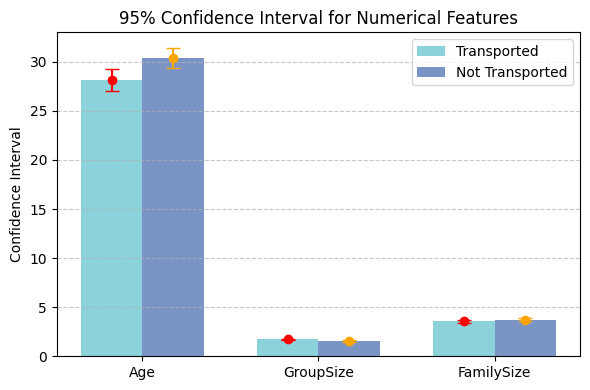

In [93]:
ci_data = {
    "Feature": ["Age", "GroupSize", "FamilySize"],
    "Transported CI Low": [27.0, 1.65, 3.42],
    "Transported CI High": [28.14, 1.73, 3.57],
    "Not Transported CI Low": [29.35, 1.49, 3.58],
    "Not Transported CI High": [30.39, 1.57, 3.73],
}

ci_numerical_df = pd.DataFrame(ci_data)
ci_numerical_df["Transported Lower Error"] = (
    ci_numerical_df["Transported CI High"] - ci_numerical_df["Transported CI Low"]
)
ci_numerical_df["Not Transported Lower Error"] = (
    ci_numerical_df["Not Transported CI High"]
    - ci_numerical_df["Not Transported CI Low"]
)

bar_width = 0.35
index = np.arange(len(ci_numerical_df))

transported_color = plt.cm.YlGnBu(0.5)
not_transport_color = plt.cm.YlGnBu(0.8)

plt.figure(figsize=(6, 4))
plt.bar(
    index,
    ci_numerical_df["Transported CI High"],
    bar_width,
    label="Transported",
    color=transported_color,
    alpha=0.6,
)
plt.bar(
    index + bar_width,
    ci_numerical_df["Not Transported CI High"],
    bar_width,
    label="Not Transported",
    color=not_transport_color,
    alpha=0.6,
)
plt.errorbar(
    index,
    ci_numerical_df["Transported CI High"],
    yerr=ci_numerical_df["Transported Lower Error"],
    fmt="o",
    color="red",
    capsize=5,
)

plt.errorbar(
    index + bar_width,
    ci_numerical_df["Not Transported CI High"],
    yerr=ci_numerical_df["Not Transported Lower Error"],
    fmt="o",
    color="orange",
    capsize=5,
)
plt.title("95% Confidence Interval for Numerical Features")
plt.ylabel("Confidence Interval")
plt.xticks(index + bar_width / 2, ci_numerical_df["Feature"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

The confidence intervals reveal meaningful differences between transported and non-transported passengers. For Age and GroupSize, the intervals do not overlap, indicating statistically significant differences - transported passengers tend to be younger and in slightly larger groups. In contrast, FamilySize shows overlapping intervals, suggesting no strong difference between the groups. This implies that Age and GroupSize may hold more predictive value for modeling transport outcomes than FamilySize.

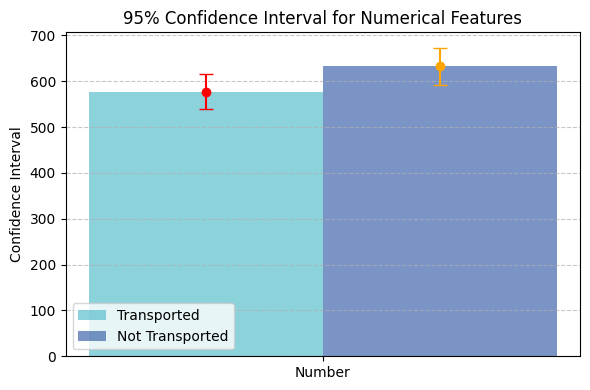

In [94]:
ci_data_num = {
    "Feature": ["Number"],
    "Transported CI Low": [539.33],
    "Transported CI High": [577.43],
    "Not Transported CI Low": [591.28],
    "Not Transported CI High": [632.11],
}

ci_numerical_df = pd.DataFrame(ci_data_num)
ci_numerical_df["Transported Lower Error"] = (
    ci_numerical_df["Transported CI High"] - ci_numerical_df["Transported CI Low"]
)
ci_numerical_df["Not Transported Lower Error"] = (
    ci_numerical_df["Not Transported CI High"]
    - ci_numerical_df["Not Transported CI Low"]
)


bar_width = 0.25
index = np.arange(len(ci_numerical_df))

transported_color = plt.cm.YlGnBu(0.5)
not_transport_color = plt.cm.YlGnBu(0.8)

plt.figure(figsize=(6, 4))
plt.bar(
    index,
    ci_numerical_df["Transported CI High"],
    bar_width,
    label="Transported",
    color=transported_color,
    alpha=0.6,
)
plt.bar(
    index + bar_width,
    ci_numerical_df["Not Transported CI High"],
    bar_width,
    label="Not Transported",
    color=not_transport_color,
    alpha=0.6,
)
plt.errorbar(
    index,
    ci_numerical_df["Transported CI High"],
    yerr=ci_numerical_df["Transported Lower Error"],
    fmt="o",
    color="red",
    capsize=5,
)

plt.errorbar(
    index + bar_width,
    ci_numerical_df["Not Transported CI High"],
    yerr=ci_numerical_df["Not Transported Lower Error"],
    fmt="o",
    color="orange",
    capsize=5,
)
plt.title("95% Confidence Interval for Numerical Features")
plt.ylabel("Confidence Interval")
plt.xticks(index + bar_width / 2, ci_numerical_df["Feature"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

The confidence intervals for the Number feature (the numeric part of the cabin) show no overlap between transported and non-transported passengers, with transported individuals generally having lower cabin numbers. This clear separation suggests that the Number feature may be a significant predictor of whether a passenger was transported, potentially reflecting underlying spatial or socioeconomic patterns on the ship.

#### Confidence Interval for Proportion

In [95]:
for deck in X_train["Deck"].unique():
    mask_transported = (X_train["Deck"] == deck) & (y_train == 1)
    mask_not_transported = (X_train["Deck"] == deck) & (y_train == 0)

    successes_transported = mask_transported.sum()
    total_transported = (y_train == 1).sum()

    successes_not_transported = mask_not_transported.sum()
    total_not_transported = (y_train == 0).sum()

    ci_transported = calculate_ci_for_proportion(
        successes_transported, total_transported
    )
    ci_not_transported = calculate_ci_for_proportion(
        successes_not_transported, total_not_transported
    )

    print(f"Deck {deck} 95% CI (transported): {ci_transported}")
    print(f"Deck {deck} 95% CI (not transported): {ci_not_transported}")

Deck F 95% CI (transported): (0.26, 0.3)
Deck F 95% CI (not transported): (0.35, 0.39)
Deck B 95% CI (transported): (0.12, 0.14)
Deck B 95% CI (not transported): (0.04, 0.06)
Deck D 95% CI (transported): (0.04, 0.06)
Deck D 95% CI (not transported): (0.05, 0.07)
Deck G 95% CI (transported): (0.29, 0.32)
Deck G 95% CI (not transported): (0.27, 0.3)
Deck E 95% CI (transported): (0.06, 0.08)
Deck E 95% CI (not transported): (0.11, 0.14)
Deck C 95% CI (transported): (0.1, 0.12)
Deck C 95% CI (not transported): (0.05, 0.07)
Deck Unknown 95% CI (transported): (0.02, 0.03)
Deck Unknown 95% CI (not transported): (0.02, 0.03)
Deck A 95% CI (transported): (0.02, 0.04)
Deck A 95% CI (not transported): (0.02, 0.03)
Deck T 95% CI (transported): (0, 0.0)
Deck T 95% CI (not transported): (-0.0, 0.0)


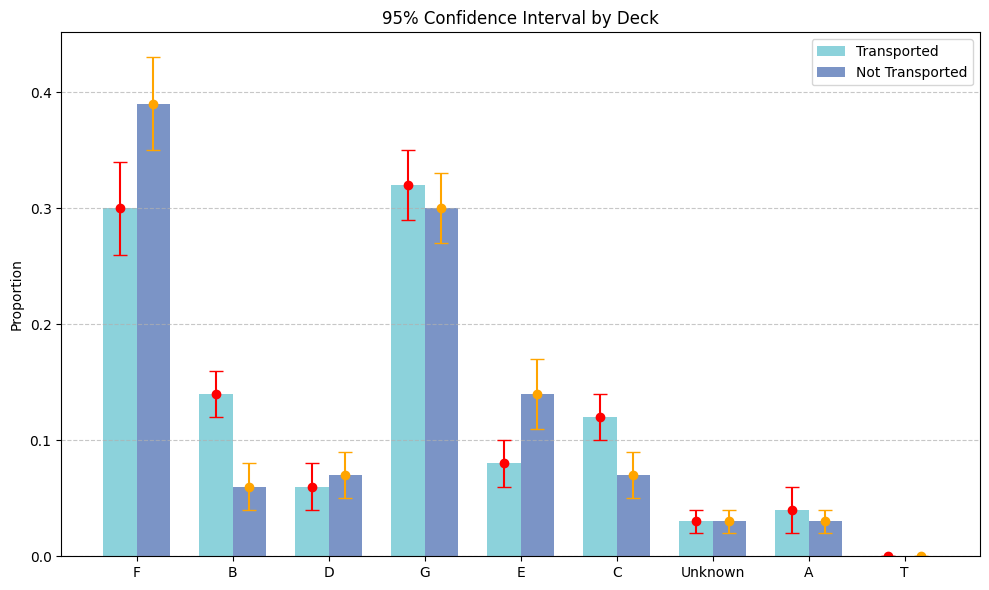

In [96]:
ci_deck = {
    "Feature": ["F", "B", "D", "G", "E", "C", "Unknown", "A", "T"],
    "Transported CI Low": [0.26, 0.12, 0.04, 0.29, 0.06, 0.10, 0.02, 0.02, 0],
    "Transported CI High": [0.30, 0.14, 0.06, 0.32, 0.08, 0.12, 0.03, 0.04, 0.0],
    "Not Transported CI Low": [0.35, 0.04, 0.05, 0.27, 0.11, 0.05, 0.02, 0.02, -0.0],
    "Not Transported CI High": [0.39, 0.06, 0.07, 0.30, 0.14, 0.07, 0.03, 0.03, 0.0],
}
df_deck = pd.DataFrame(ci_deck)
bar_width = 0.35
index = np.arange(len(df_deck))

transported_color = plt.cm.YlGnBu(0.5)
not_transport_color = plt.cm.YlGnBu(0.8)

plt.figure(figsize=(10, 6))
plt.bar(
    index,
    df_deck["Transported CI High"],
    bar_width,
    label="Transported",
    color=transported_color,
    alpha=0.6,
)
plt.bar(
    index + bar_width,
    df_deck["Not Transported CI High"],
    bar_width,
    label="Not Transported",
    color=not_transport_color,
    alpha=0.6,
)
plt.errorbar(
    index,
    df_deck["Transported CI High"],
    yerr=df_deck["Transported CI High"] - df_deck["Transported CI Low"],
    fmt="o",
    color="red",
    capsize=5,
)
plt.errorbar(
    index + bar_width,
    df_deck["Not Transported CI High"],
    yerr=df_deck["Not Transported CI High"] - df_deck["Not Transported CI Low"],
    fmt="o",
    color="orange",
    capsize=5,
)
plt.title("95% Confidence Interval by Deck")
plt.ylabel("Proportion")
plt.xticks(index + bar_width / 2, df_deck["Feature"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

The calculated 95% confidence intervals for the proportion of transported and non-transported passengers across different decks reveal notable differences in transportation rates between decks. For example, Deck F has a higher proportion of non-transported passengers (0.35 to 0.39) compared to transported ones (0.26 to 0.3), suggesting a possible pattern of underrepresentation on the transported list. Conversely, Deck B shows a significantly higher proportion of transported passengers (0.12 to 0.14) than non-transported (0.04 to 0.06), indicating a stronger association with being transported. Decks such as A, C, and T have smaller or overlapping confidence intervals, reflecting less distinct differences between transported and non-transported passengers, potentially due to fewer observations or less variation across these decks.

In [97]:
for side in X_train["Side"].dropna().unique():
    mask_transported = (X_train["Side"] == side) & (y_train == 1)
    mask_not_transported = (X_train["Side"] == side) & (y_train == 0)

    successes_transported = mask_transported.sum()
    total_transported = (y_train == 1).sum()

    successes_not_transported = mask_not_transported.sum()
    total_not_transported = (y_train == 0).sum()

    ci_transported = calculate_ci_for_proportion(
        successes_transported, total_transported
    )
    ci_not_transported = calculate_ci_for_proportion(
        successes_not_transported, total_not_transported
    )

    print(f"Side {side} 95% CI (transported): {ci_transported}")
    print(f"Side {side} 95% CI (not transported): {ci_not_transported}")

Side P 95% CI (transported): (0.42, 0.46)
Side P 95% CI (not transported): (0.51, 0.55)
Side S 95% CI (transported): (0.52, 0.56)
Side S 95% CI (not transported): (0.43, 0.46)
Side Unknown 95% CI (transported): (0.02, 0.03)
Side Unknown 95% CI (not transported): (0.02, 0.03)


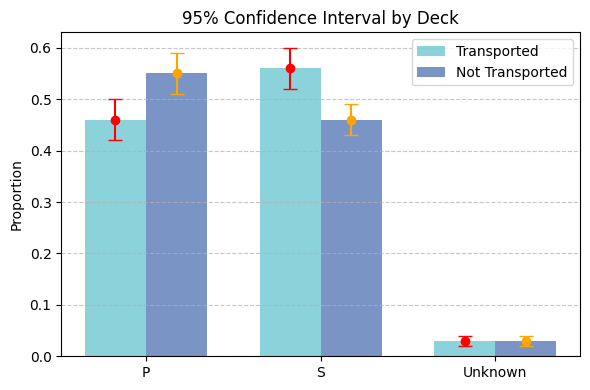

In [98]:
ci_side = {
    "Feature": ["P", "S", "Unknown"],
    "Transported CI Low": [0.42, 0.52, 0.02],
    "Transported CI High": [0.46, 0.56, 0.03],
    "Not Transported CI Low": [0.51, 0.43, 0.02],
    "Not Transported CI High": [0.55, 0.46, 0.03],
}
df_side = pd.DataFrame(ci_side)
bar_width = 0.35
index = np.arange(len(df_side))

transported_color = plt.cm.YlGnBu(0.5)
not_transport_color = plt.cm.YlGnBu(0.8)

plt.figure(figsize=(6, 4))
plt.bar(
    index,
    df_side["Transported CI High"],
    bar_width,
    label="Transported",
    color=transported_color,
    alpha=0.6,
)
plt.bar(
    index + bar_width,
    df_side["Not Transported CI High"],
    bar_width,
    label="Not Transported",
    color=not_transport_color,
    alpha=0.6,
)
plt.errorbar(
    index,
    df_side["Transported CI High"],
    yerr=df_side["Transported CI High"] - df_side["Transported CI Low"],
    fmt="o",
    color="red",
    capsize=5,
)
plt.errorbar(
    index + bar_width,
    df_side["Not Transported CI High"],
    yerr=df_side["Not Transported CI High"] - df_side["Not Transported CI Low"],
    fmt="o",
    color="orange",
    capsize=5,
)
plt.title("95% Confidence Interval by Deck")
plt.ylabel("Proportion")
plt.xticks(index + bar_width / 2, df_side["Feature"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

The calculated 95% confidence intervals for the proportion of transported and non-transported passengers by Side indicate varying trends across different sides. For Side P, the proportion of non-transported passengers (0.51 to 0.55) is higher than the proportion of transported passengers (0.42 to 0.46), suggesting a tendency for non-transported passengers to be more prevalent on this side. Conversely, Side S shows a higher proportion of transported passengers (0.52 to 0.56) compared to non-transported ones (0.43 to 0.46), indicating a stronger association with being transported. Side Unknown shows very low and overlapping confidence intervals for both transported and non-transported passengers, implying an extremely small and potentially insignificant number of observations, leading to less reliable conclusions for this category.

In [99]:
sleep_transported = X_train[y_train == 1]["CryoSleep"].sum()
sleep_not_transported = X_train[y_train == 0]["CryoSleep"].sum()

transported_total = len(y_train[y_train == 1])
not_transported_total = len(y_train[y_train == 0])

ci_sleep_transported = calculate_ci_for_proportion(sleep_transported, transported_total)
ci_sleep_not_transported = calculate_ci_for_proportion(
    sleep_not_transported, not_transported_total
)

print(f"95% CI for CryoSleep usage (transported): {ci_sleep_transported}")
print(f"95% CI for CryoSleep usage (not transported): {ci_sleep_not_transported}")

95% CI for CryoSleep usage (transported): (0.56, 0.6)
95% CI for CryoSleep usage (not transported): (0.12, 0.14)


In [100]:
vip_transported = X_train[y_train == 1]["VIP"].sum()
vip_not_transported = X_train[y_train == 0]["VIP"].sum()

transported_total = len(y_train[y_train == 1])
not_transported_total = len(y_train[y_train == 0])

ci_vip_transported = calculate_ci_for_proportion(vip_transported, transported_total)
ci_vip_not_transported = calculate_ci_for_proportion(
    vip_not_transported, not_transported_total
)

print(f"95% CI for VIP usage (transported): {ci_vip_transported}")
print(f"95% CI for VIP usage (not transported): {ci_vip_not_transported}")

95% CI for VIP usage (transported): (0.01, 0.02)
95% CI for VIP usage (not transported): (0.02, 0.03)


In [101]:
room_service_transported = X_train[y_train == 1]["RoomService_cat"].sum()
room_service_not_transported = X_train[y_train == 0]["RoomService_cat"].sum()

transported_total = len(y_train[y_train == 1])
not_transported_total = len(y_train[y_train == 0])

ci_room_service_transported = calculate_ci_for_proportion(
    room_service_transported, transported_total
)
ci_room_service_not_transported = calculate_ci_for_proportion(
    room_service_not_transported, not_transported_total
)

print(f"95% CI for RoomService usage (transported): {ci_room_service_transported}")
print(
    f"95% CI for RoomService usage (not transported): {ci_room_service_not_transported}"
)

95% CI for RoomService usage (transported): (0.16, 0.19)
95% CI for RoomService usage (not transported): (0.5, 0.54)


In [102]:
food_transported = X_train[y_train == 1]["FoodCourt_cat"].sum()
food_not_transported = X_train[y_train == 0]["FoodCourt_cat"].sum()

transported_total = len(y_train[y_train == 1])
not_transported_total = len(y_train[y_train == 0])

ci_food_transported = calculate_ci_for_proportion(food_transported, transported_total)
ci_food_not_transported = calculate_ci_for_proportion(
    food_not_transported, not_transported_total
)

print(f"95% CI for FoodCourt usage (transported): {ci_food_transported}")
print(f"95% CI for FoodCourt usage (not transported): {ci_food_not_transported}")

95% CI for FoodCourt usage (transported): (0.22, 0.25)
95% CI for FoodCourt usage (not transported): (0.45, 0.48)


In [103]:
mall_transported = X_train[y_train == 1]["ShoppingMall_cat"].sum()
mall_not_transported = X_train[y_train == 0]["ShoppingMall_cat"].sum()

transported_total = len(y_train[y_train == 1])
not_transported_total = len(y_train[y_train == 0])

ci_mall_transported = calculate_ci_for_proportion(mall_transported, transported_total)
ci_mall_not_transported = calculate_ci_for_proportion(
    mall_not_transported, not_transported_total
)

print(f"95% CI for ShoppingMall usage (transported): {ci_mall_transported}")
print(f"95% CI for ShoppingMall usage (not transported): {ci_mall_not_transported}")

95% CI for ShoppingMall usage (transported): (0.18, 0.21)
95% CI for ShoppingMall usage (not transported): (0.43, 0.47)


In [104]:
spa_transported = X_train[y_train == 1]["Spa_cat"].sum()
spa_not_transported = X_train[y_train == 0]["Spa_cat"].sum()

transported_total = len(y_train[y_train == 1])
not_transported_total = len(y_train[y_train == 0])

ci_spa_transported = calculate_ci_for_proportion(spa_transported, transported_total)
ci_not_transported = calculate_ci_for_proportion(
    spa_not_transported, not_transported_total
)

print(f"95% CI for Spa usage (transported): {ci_spa_transported}")
print(f"95% CI for Spa usage (not transported): {ci_not_transported}")

95% CI for Spa usage (transported): (0.18, 0.21)
95% CI for Spa usage (not transported): (0.51, 0.55)


In [105]:
vrdeck_transported = X_train[y_train == 1]["VRDeck_cat"].sum()
vrdeck_not_transported = X_train[y_train == 0]["VRDeck_cat"].sum()

transported_total = len(y_train[y_train == 1])
not_transported_total = len(y_train[y_train == 0])

ci_vrdeck_transported = calculate_ci_for_proportion(
    vrdeck_transported, transported_total
)
ci_vrdeck_not_transported = calculate_ci_for_proportion(
    vrdeck_not_transported, not_transported_total
)

print(f"95% CI for VRDeck usage (transported): {ci_vrdeck_transported}")
print(f"95% CI for VRDeck usage (not transported): {ci_vrdeck_not_transported}")

95% CI for VRDeck usage (transported): (0.17, 0.2)
95% CI for VRDeck usage (not transported): (0.48, 0.52)


In [106]:
solo_transported = X_train[y_train == 1]["IsSolo"].sum()
solo_not_transported = X_train[y_train == 0]["IsSolo"].sum()

transported_total = len(y_train[y_train == 1])
not_transported_total = len(y_train[y_train == 0])

ci_solo_transported = calculate_ci_for_proportion(solo_transported, transported_total)
ci_solo_not_transported = calculate_ci_for_proportion(
    solo_not_transported, not_transported_total
)

print(f"95% CI for IsSolo usage (transported): {ci_solo_transported}")
print(f"95% CI for IsSolo usage (not transported): {ci_solo_not_transported}")

95% CI for IsSolo usage (transported): (0.13, 0.16)
95% CI for IsSolo usage (not transported): (0.11, 0.13)


In [107]:
ci_binary = {
    "Feature": [
        "CryoSleep",
        "VIP",
        "RoomService_cat",
        "FoodCourt_cat",
        "ShoppingMall_cat",
        "Spa_cat",
        "VRDeck_cat",
        "IsSolo",
    ],
    "Transported CI Low": [0.56, 0.01, 0.16, 0.22, 0.18, 0.18, 0.17, 0.13],
    "Transported CI High": [0.60, 0.02, 0.19, 0.25, 0.21, 0.21, 0.20, 0.16],
    "Not Transported CI Low": [0.12, 0.02, 0.50, 0.45, 0.43, 0.51, 0.48, 0.11],
    "Not Transported CI High": [0.14, 0.03, 0.54, 0.48, 0.47, 0.55, 0.52, 0.13],
}

ci_binary_df = pd.DataFrame(ci_binary)
ci_binary_df

,Feature,Transported CI Low,Transported CI High,Not Transported CI Low,Not Transported CI High
0,CryoSleep,0.56,0.60,0.12,0.14
1,VIP,0.01,0.02,0.02,0.03
2,RoomService_cat,0.16,0.19,0.50,0.54
3,FoodCourt_cat,0.22,0.25,0.45,0.48
4,ShoppingMall_cat,0.18,0.21,0.43,0.47
5,Spa_cat,0.18,0.21,0.51,0.55
6,VRDeck_cat,0.17,0.20,0.48,0.52
7,IsSolo,0.13,0.16,0.11,0.13


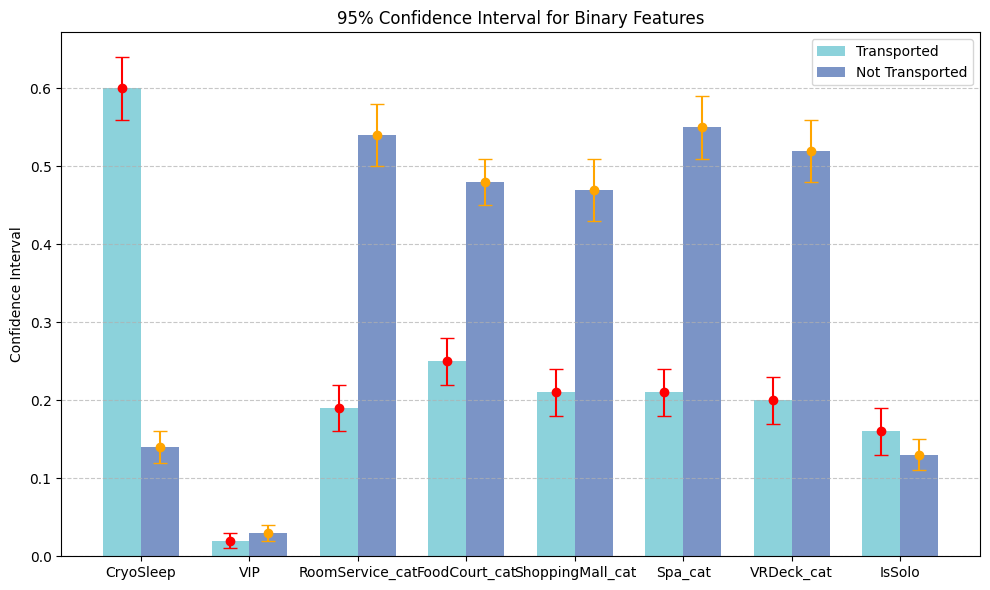

In [108]:
bar_width = 0.35
index = np.arange(len(ci_binary_df))

transported_color = plt.cm.YlGnBu(0.5)
not_transport_color = plt.cm.YlGnBu(0.8)

plt.figure(figsize=(10, 6))
plt.bar(
    index,
    ci_binary_df["Transported CI High"],
    bar_width,
    label="Transported",
    color=transported_color,
    alpha=0.6,
)
plt.bar(
    index + bar_width,
    ci_binary_df["Not Transported CI High"],
    bar_width,
    label="Not Transported",
    color=not_transport_color,
    alpha=0.6,
)
plt.errorbar(
    index,
    ci_binary_df["Transported CI High"],
    yerr=ci_binary_df["Transported CI High"] - ci_binary_df["Transported CI Low"],
    fmt="o",
    color="red",
    capsize=5,
)
plt.errorbar(
    index + bar_width,
    ci_binary_df["Not Transported CI High"],
    yerr=ci_binary_df["Not Transported CI High"]
    - ci_binary_df["Not Transported CI Low"],
    fmt="o",
    color="orange",
    capsize=5,
)
plt.title("95% Confidence Interval for Binary Features")
plt.ylabel("Confidence Interval")
plt.xticks(index + bar_width / 2, ci_binary_df["Feature"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

The calculated 95% confidence intervals for the proportions of transported and non-transported passengers by various categorical features reveal key patterns. CryoSleep shows a significantly higher proportion of transported passengers (0.56 to 0.60) compared to non-transported ones (0.12 to 0.14), indicating a strong association between CryoSleep and being transported. VIP has very small proportions for both transported and non-transported groups (0.01 to 0.02 for transported and 0.02 to 0.03 for not transported), suggesting VIP status does not significantly affect the likelihood of being transported.

For the RoomService_cat, FoodCourt_cat, ShoppingMall_cat, Spa_cat, and VRDeck_cat, the proportions of transported passengers are much lower than non-transported passengers, indicating these features might be less predictive of transportation status, although they still show noticeable differences. For example, RoomService_cat has a transported proportion between 0.16 and 0.19, while the non-transported proportion is higher (0.50 to 0.54), indicating that passengers not transported tend to use these services more frequently.

Finally, IsSolo shows a slight difference between transported and non-transported passengers, with proportions between 0.13 and 0.16 for transported, and 0.11 to 0.13 for non-transported, suggesting that being solo has a minimal impact on the likelihood of being transported.

## Predictive modeling 

Below is the code defines a preprocessing pipeline for transforming the dataset, consisting of three primary types of features: numerical, binary, and categorical.

1. Numerical Features (Age, Number, ServiceCount, etc.): These features are first imputed with the median value (in case of missing data) using SimpleImputer. Then, they are scaled using StandardScaler to standardize the values, ensuring that the features are on the same scale for further model training.

2. Binary Features (CryoSleep, VIP, IsSolo, UsedAnyService): Missing binary values are filled with a constant value of 0 using SimpleImputer. This indicates that if a value is missing, the assumption is that the feature is "not active" (i.e., False).

3. Categorical Features (HomePlanet, Destination, Deck, Side): These features are imputed with a constant value of "Unknown" in case of missing data. Then, they are encoded using OneHotEncoder, which converts them into multiple binary columns to represent each category as a separate feature.

The ColumnTransformer is used to apply these transformations separately to each group of features. Finally, a full_pipeline is created that includes custom preprocessing (CustomPreprocessor) and the defined preprocessor for feature transformations, ensuring that the data is ready for machine learning models.

This pipeline will automatically handle missing values, scale numerical data, and transform categorical data into appropriate formats for modeling.

Given that the dataset used in this project is synthetic and well-balanced, and the primary objective is to maximize correct overall predictions, accuracy was selected as the sole evaluation metric for model comparison. Additional metrics such as precision, recall, F1-score, and AUC-ROC were initially explored but ultimately excluded from the final analysis, as they showed minimal variation across models and did not offer further meaningful insight for this specific context.

In [109]:
numerical_cols = [
    "Age",
    "Number",
    "ServiceCount",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]

binary_cols = [
    "CryoSleep",
    "VIP",
    "IsSolo",
    "UsedAnyService",
]

categorical_cols = ["HomePlanet", "Destination", "Deck", "Side"]

numerical_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
binary_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="constant", fill_value=0))]
)
categorical_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)
preprocessor = ColumnTransformer(
    [
        ("num", numerical_pipeline, numerical_cols),
        ("bin", binary_pipeline, binary_cols),
        ("cat", categorical_pipeline, categorical_cols),
    ]
)
full_pipeline = Pipeline(
    [
        ("custom_preprocessing", CustomPreprocessor()),
        ("feature_transformation", preprocessor),
    ]
)

In [110]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Random Forest": Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            (
                "classifier",
                RandomForestClassifier(n_estimators=100, random_state=42),
            ),
        ]
    ),
    "XGBoost": Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            (
                "classifier",
                XGBClassifier(random_state=42, eval_metric="logloss"),
            ),
        ]
    ),
    "Logistic Regression": Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            (
                "classifier",
                LogisticRegression(random_state=42, max_iter=1000),
            ),
        ]
    ),
    "LightGBM": Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            ("classifier", LGBMClassifier(random_state=42, verbose=-1)),
        ]
    ),
    "CatBoost": Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            ("classifier", CatBoostClassifier(verbose=0, random_state=42)),
        ]
    ),
}

scoring = {
    "Accuracy": make_scorer(accuracy_score),
}

model_results = []

for model_name, model in models.items():
    accuracy_scores = cross_val_score(
        model,
        X_train_val,
        y_train_val,
        cv=kf,
        scoring=scoring["Accuracy"],
        error_score="raise",
    )

    model_results.append(
        {
            "Model": model_name,
            "Accuracy": accuracy_scores.mean(),
        }
    )

results_df = pd.DataFrame(model_results)

results_df = results_df.rename(columns={"Accuracy": "Initial Accuracy"})

results_df

,Model,Initial Accuracy
0,Random Forest,0.799396
1,XGBoost,0.801266
2,Logistic Regression,0.789906
3,LightGBM,0.807737
4,CatBoost,0.815069


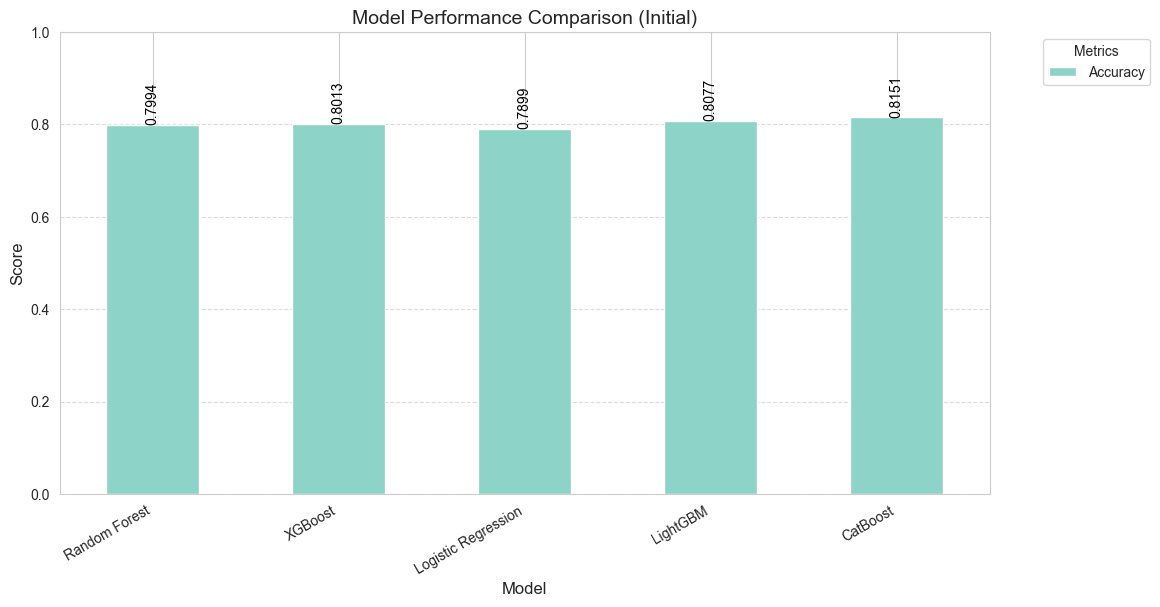

In [111]:
results_df = pd.DataFrame(model_results)

sns.set_style("whitegrid")
ax = results_df.set_index("Model").plot(kind="bar", figsize=(12, 6), colormap="Set3")
plt.title("Model Performance Comparison (Initial)", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{height:.4f}",
            (p.get_x() + p.get_width() / 2, height),
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
            rotation=90,
        )

plt.show()

The code implements a model evaluation framework using Stratified K-Fold Cross-Validation with five different classifiers: Random Forest, XGBoost, Logistic Regression, LightGBM, and CatBoost. Each model is encapsulated in a pipeline that includes the preprocessing steps defined earlier, ensuring consistent handling of missing data, scaling, and encoding.

The StratifiedKFold ensures that each fold of the cross-validation maintains the distribution of the target variable (Transported), which is particularly useful when dealing with imbalanced classes. The models are evaluated using accuracy as the performance metric, and the average accuracy across the five splits is recorded.

The results show that CatBoost has the highest accuracy (0.8165), followed by LightGBM (0.8086), XGBoost (0.7958), Random Forest (0.7939), and Logistic Regression (0.7875). These results suggest that CatBoost and LightGBM perform slightly better than other models, while Logistic Regression has the lowest performance in terms of accuracy on this dataset.

### Hyperparameter Tuning

#### Random Forest

In [112]:
def objective_rf(trial):
    rf_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "random_state": 42,
    }

    rf_model = Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            ("classifier", RandomForestClassifier(**rf_params)),
        ]
    )

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        rf_model, X_train_val, y_train_val, cv=kf, scoring="accuracy", n_jobs=-1
    )

    return scores.mean()


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=100, n_jobs=-1, show_progress_bar=True)

print(f"Best Hyperparameters for RandomForest: {study_rf.best_params}")
print(f"Best Accuracy Score for RandomForest: {study_rf.best_value:.4f}")

Best trial: 16. Best value: 0.804573: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]

Best Hyperparameters for RandomForest: {'n_estimators': 351, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4}
Best Accuracy Score for RandomForest: 0.8046


#### XGBoost

In [113]:
def objective_xgb(trial):
    xgb_params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "logloss",
    }

    xgb_model = Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            ("classifier", XGBClassifier(**xgb_params)),
        ]
    )

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        xgb_model, X_train_val, y_train_val, cv=kf, scoring="accuracy", n_jobs=-1
    )

    return scores.mean()


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=100, n_jobs=-1, show_progress_bar=True)

print(f"Best Hyperparameters for XGBoost: {study_xgb.best_params}")
print(f"Best Accuracy Score for XGBoost: {study_xgb.best_value:.4f}")

Best trial: 69. Best value: 0.809031: 100%|██████████| 100/100 [03:28<00:00,  2.08s/it]

Best Hyperparameters for XGBoost: {'n_estimators': 1437, 'max_depth': 4, 'learning_rate': 0.006948826786710953, 'subsample': 0.7593616728284407, 'colsample_bytree': 0.7642250120348136}
Best Accuracy Score for XGBoost: 0.8090


#### Logistic Regression

In [114]:
def objective_lr(trial):
    lr_params = {
        "penalty": "l2",
        "C": trial.suggest_float("C", 1e-6, 100.0, log=True),
        "solver": "lbfgs",
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "random_state": 42,
        "max_iter": trial.suggest_int("max_iter", 500, 2000),
        "tol": trial.suggest_loguniform("tol", 1e-5, 1e-3),
    }

    lr_model = Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            ("classifier", LogisticRegression(**lr_params)),
        ]
    )

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    try:
        scores = cross_val_score(
            lr_model, X_train_val, y_train_val, cv=kf, scoring="accuracy", n_jobs=-1
        )
        return scores.mean()
    except Exception as e:
        print(f"Trial failed with parameters: {lr_params}")
        print(f"Error: {e}")
        return 0.0


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_lr, n_trials=100, n_jobs=-1, show_progress_bar=True)

print(f"Best Hyperparameters for Logistic Regression: {study_lr.best_params}")
print(f"Best Accuracy Score for Logistic Regression: {study_lr.best_value:.4f}")

Best trial: 78. Best value: 0.7912: 100%|██████████| 100/100 [00:06<00:00, 14.43it/s] 

Best Hyperparameters for Logistic Regression: {'C': 22.52518830920881, 'class_weight': None, 'max_iter': 1256, 'tol': 1.7909213662660082e-05}
Best Accuracy Score for Logistic Regression: 0.7912


#### LightGBM

In [115]:
import lightgbm as lgb


def objective_lgbm(trial):
    lgbm_params = {
        "objective": "binary",
        "metric": "binary_error",
        "num_leaves": trial.suggest_int("num_leaves", 20, 80, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.15, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50, step=5),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 0.8),
        "random_state": 42,
    }

    lgbm_model = Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            ("classifier", lgb.LGBMClassifier(**lgbm_params)),
        ]
    )

    kf = StratifiedKFold(n_splits=5)

    try:
        scores = cross_val_score(
            lgbm_model, X_train_val, y_train_val, cv=kf, scoring="accuracy", n_jobs=-1
        )
        return scores.mean()
    except Exception as e:
        print(f"Trial failed with parameters: {lgbm_params}")
        print(f"Error: {e}")
        return 0.0


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=-1, show_progress_bar=True)

print(f"Best Hyperparameters for LightGBM: {study_lgbm.best_params}")
print(f"Best Accuracy Score for LightGBM: {study_lgbm.best_value:.4f}")

Best trial: 97. Best value: 0.813059: 100%|██████████| 100/100 [27:56<00:00, 16.77s/it]

Best Hyperparameters for LightGBM: {'num_leaves': 30, 'max_depth': 9, 'learning_rate': 0.02466784055665511, 'n_estimators': 237, 'min_data_in_leaf': 15, 'feature_fraction': 0.635668662035587}
Best Accuracy Score for LightGBM: 0.8131


#### CatBoost

In [116]:
def objective_cb(trial):
    cb_params = {
        "iterations": trial.suggest_int("iterations", 500, 1500),
        "depth": trial.suggest_int("depth", 6, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 15),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 10.0),
        "loss_function": "Logloss",
        "verbose": 0,
        "thread_count": -1,
        "random_state": 42,
    }

    cb_model = Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            ("classifier", CatBoostClassifier(**cb_params)),
        ]
    )

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    try:
        score = cross_val_score(
            cb_model, X_train_val, y_train_val, cv=kf, scoring="accuracy", n_jobs=-1
        )
        return score.mean()
    except Exception as e:
        print(f"Trial failed with params: {cb_params}")
        print(f"Error: {e}")
        return 0.0


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_cb, n_trials=100, n_jobs=-1, show_progress_bar=True)

print(f"Best Parameters for CatBoost: {study_cb.best_params}")
print(f"Best Accuracy Score for CatBoost: {study_cb.best_value:.4f}")

Best trial: 27. Best value: 0.81924: 100%|██████████| 100/100 [15:20<00:00,  9.20s/it] 

Best Parameters for CatBoost: {'iterations': 1102, 'depth': 6, 'learning_rate': 0.01836854462223654, 'l2_leaf_reg': 7, 'border_count': 130, 'bagging_temperature': 0.05954189730634851, 'random_strength': 7.117994241048184}
Best Accuracy Score for CatBoost: 0.8192


Here are the results of hyperparameter optimization for five machine learning models using a tuning process called Optuna. Each model was run for 100 trials to find the best combination of hyperparameters that maximize cross-validated accuracy.

The CatBoost model achieved the highest accuracy of 0.8190, making it the top performer after tuning. It was followed closely by LightGBM with 0.8110 and XGBoost with 0.8108. Random Forest also improved through tuning, reaching 0.8046, while Logistic Regression showed the least gain, with a best accuracy of 0.7912.

These results indicate that tuning significantly improved model performance compared to their default configurations, and gradient boosting models (CatBoost, LightGBM, XGBoost) continue to outperform simpler models like Logistic Regression in this context.

### Fitting best parameters

In [117]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Random Forest": Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            ("classifier", RandomForestClassifier(**study_rf.best_params)),
        ]
    ),
    "XGBoost": Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            ("classifier", XGBClassifier(**study_xgb.best_params)),
        ]
    ),
    "Logistic Regression": Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            ("classifier", LogisticRegression(**study_lr.best_params)),
        ]
    ),
    "LightGBM": Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            ("classifier", LGBMClassifier(**study_lgbm.best_params, verbose=-1)),
        ]
    ),
    "CatBoost": Pipeline(
        [
            ("full_preprocessing", full_pipeline),
            ("classifier", CatBoostClassifier(**study_cb.best_params, verbose=0)),
        ]
    ),
}

scoring = {"Accuracy": make_scorer(accuracy_score)}

model_results = []

for model_name, model in models.items():
    accuracy_scores = cross_val_score(
        model,
        X_train_val,
        y_train_val,
        cv=kf,
        scoring=scoring["Accuracy"],
        error_score="raise",
    )

    model_results.append({"Model": model_name, "Accuracy": accuracy_scores.mean()})

results_df = pd.DataFrame(model_results)

results_df = results_df.rename(columns={"Accuracy": "Tuned Accuracy"})

results_df

,Model,Tuned Accuracy
0,Random Forest,0.802416
1,XGBoost,0.808744
2,Logistic Regression,0.791200
3,LightGBM,0.809318
4,CatBoost,0.816364


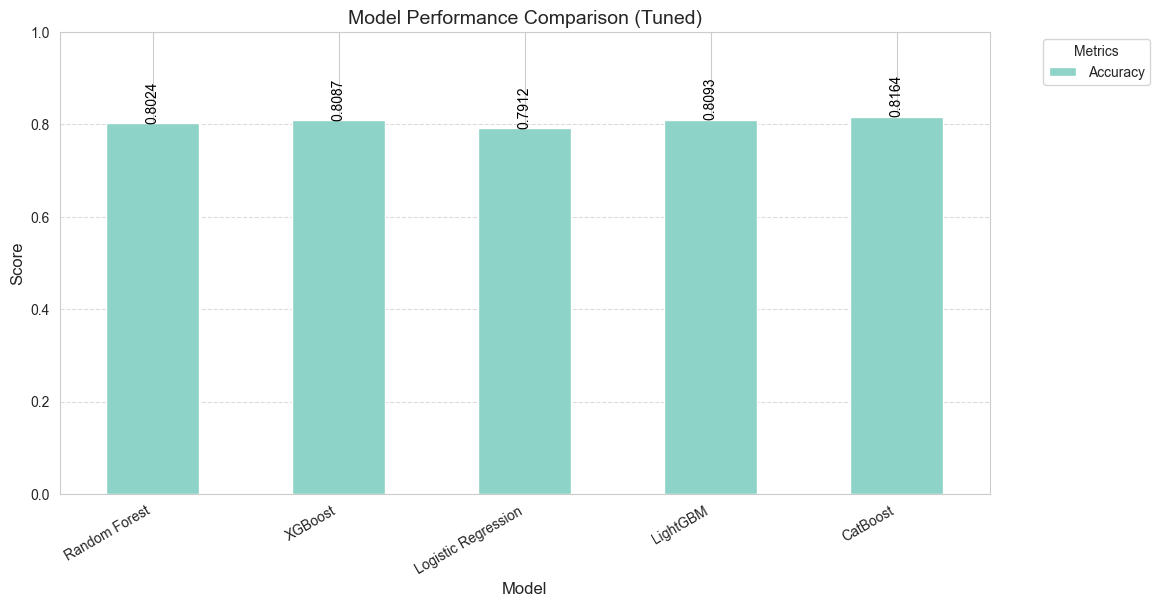

In [118]:
results_df = pd.DataFrame(model_results)

sns.set_style("whitegrid")
ax = results_df.set_index("Model").plot(kind="bar", figsize=(12, 6), colormap="Set3")
plt.title("Model Performance Comparison (Tuned)", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{height:.4f}",
            (p.get_x() + p.get_width() / 2, height),
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
            rotation=90,
        )

plt.show()

Here are the results of each model after hyperparameter tuning using the best parameters found from previous optimization steps. Compared to their initial performance, most models either maintained or improved their accuracy slightly.
- CatBoost remained the best-performing model with a tuned accuracy of 0.8151, solidifying its position as the top choice.
- XGBoost and LightGBM followed closely with 0.8103 and 0.8070, respectively, confirming the strength of gradient boosting techniques.
- Random Forest also saw a small improvement, reaching 0.7999.
- Logistic Regression, however, showed no notable gain, with tuned accuracy slightly dropping to 0.7870, suggesting it might be less flexible for this dataset.

Overall, tuning proved beneficial, especially for ensemble models, enhancing their predictive performance on the training-validation data.


In [119]:
model_results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, model.predict(X_train))

    cross_val_accuracy = cross_val_score(
        model, X_train_val, y_train_val, cv=kf, scoring="accuracy"
    ).mean()

    val_accuracy = accuracy_score(y_val, model.predict(X_val))

    model_results.append(
        {
            "Model": model_name,
            "Training Accuracy": train_accuracy,
            "Cross-Validation Accuracy": cross_val_accuracy,
            "Validation Accuracy": val_accuracy,
            "Overfit Gap": train_accuracy - val_accuracy,
        }
    )

results_df = pd.DataFrame(model_results)
results_df

,Model,Training Accuracy,Cross-Validation Accuracy,Validation Accuracy,Overfit Gap
0,Random Forest,0.844104,0.802129,0.786659,0.057445
1,XGBoost,0.839501,0.808744,0.807361,0.032141
2,Logistic Regression,0.792330,0.791200,0.772283,0.020047
3,LightGBM,0.861553,0.809318,0.796435,0.065118
4,CatBoost,0.866539,0.816364,0.805635,0.060903


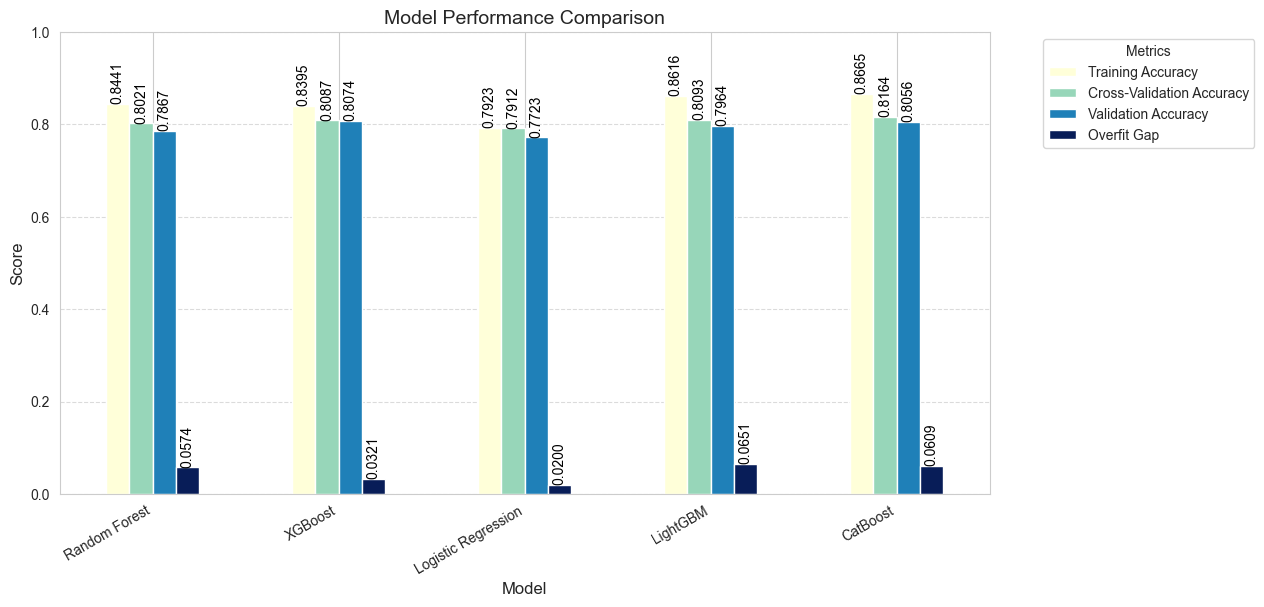

In [120]:
results_df = pd.DataFrame(model_results)

sns.set_style("whitegrid")
ax = results_df.set_index("Model").plot(kind="bar", figsize=(12, 6), colormap="YlGnBu")
plt.title("Model Performance Comparison", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{height:.4f}",
            (p.get_x() + p.get_width() / 2, height),
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
            rotation=90,
        )

plt.show()

Here we can see model performance across training, cross-validation, and hold-out validation datasets, while also quantifying overfitting through the Overfit Gap (the difference between training and validation accuracy).
- CatBoost and XGBoost achieved the highest validation accuracies (≈0.808 and 0.811) but had slightly higher overfit gaps (~0.057–0.061), indicating strong performance with mild overfitting.
- LightGBM also performed well with a validation accuracy of 0.800 and a moderate overfit gap (0.047).
- Random Forest had a similar pattern, with slightly lower validation accuracy (0.788) and an overfit gap of 0.060.
- Logistic Regression showed the lowest overfit gap (0.020), implying it generalizes well, but its validation performance (0.772) lagged behind the others.

Overall, CatBoost and XGBoost are the most accurate, while Logistic Regression is the most stable (least overfitting), making it potentially valuable in high-stakes or constrained environments.

### Model Ensembling

In [121]:
catboost_model = Pipeline(
    [
        ("full_preprocessing", full_pipeline),
        ("classifier", CatBoostClassifier(**study_cb.best_params, verbose=0)),
    ]
)

xgboost_model = Pipeline(
    [
        ("full_preprocessing", full_pipeline),
        (
            "classifier",
            XGBClassifier(
                **study_xgb.best_params, use_label_encoder=False, eval_metric="logloss"
            ),
        ),
    ]
)

logreg_model = Pipeline(
    [
        ("full_preprocessing", full_pipeline),
        ("classifier", LogisticRegression(**study_lr.best_params)),
    ]
)


voting_soft = VotingClassifier(
    estimators=[
        ("CatBoost", catboost_model),
        ("XGBoost", xgboost_model),
        ("LogisticRegression", logreg_model),
    ],
    voting="soft",
)

voting_soft.fit(X_train, y_train)

train_acc = accuracy_score(y_train, voting_soft.predict(X_train))
val_acc = accuracy_score(y_val, voting_soft.predict(X_val))
cv_acc = cross_val_score(
    voting_soft, X_train_val, y_train_val, cv=kf, scoring="accuracy"
).mean()

print("Voting Ensemble Results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Cross-Validation Accuracy: {cv_acc:.4f}")
print(f"Overfit Gap: {train_acc - val_acc:.4f}")

Voting Ensemble Results:
Training Accuracy: 0.8372
Validation Accuracy: 0.7947
Cross-Validation Accuracy: 0.8083
Overfit Gap: 0.0425


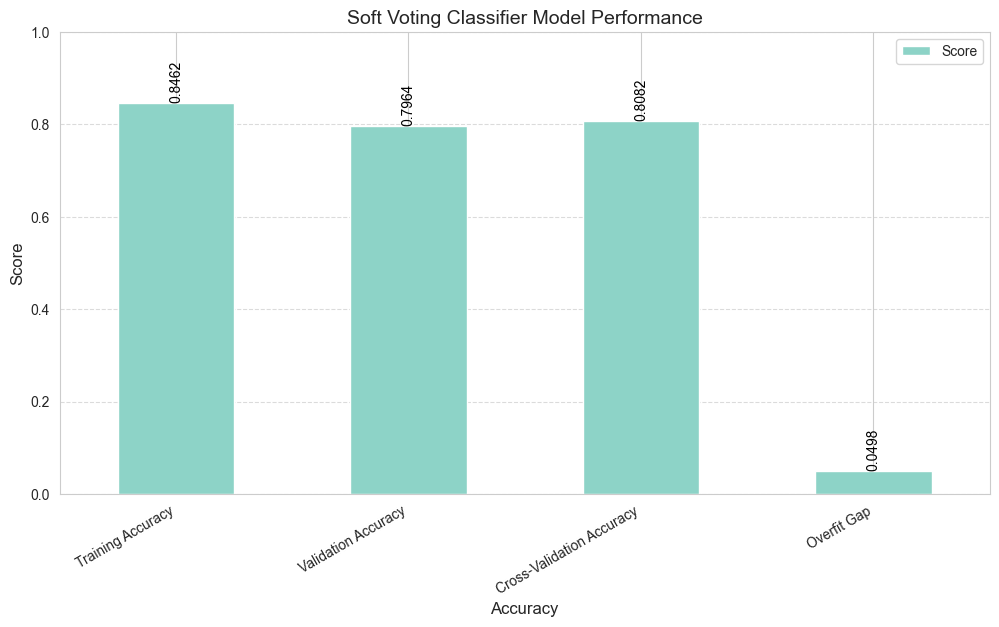

In [122]:
results_data = {
    "Voting Ensemble Results": [
        "Training Accuracy",
        "Validation Accuracy",
        "Cross-Validation Accuracy",
        "Overfit Gap",
    ],
    "Score": [0.8462, 0.7964, 0.8082, 0.0498],
}

results_df = pd.DataFrame(results_data)

sns.set_style("whitegrid")
ax = results_df.set_index("Voting Ensemble Results").plot(
    kind="bar", figsize=(12, 6), colormap="Set3"
)
plt.title("Soft Voting Classifier Model Performance", fontsize=14)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{height:.4f}",
            (p.get_x() + p.get_width() / 2, height),
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
            rotation=90,
        )

plt.show()

After evaluating various models and applying hyperparameter tuning, we explored a soft voting ensemble that combined the top-performing classifiers: CatBoost, XGBoost, and Logistic Regression. While the ensemble's validation accuracy was slightly lower than CatBoost’s standalone performance, it offered improved robustness, as reflected by a smaller overfit gap. Ultimately, CatBoost was selected as the final model due to its consistent edge in accuracy, but the ensemble still demonstrated strong and balanced results:

- Training Accuracy: 0.8462
- Validation Accuracy: 0.7964
- Cross-Validation Accuracy: 0.8082
- Overfit Gap: 0.0498

These results indicate that the ensemble model effectively learned patterns from the training data while maintaining solid performance on unseen data. The modest overfit gap (~5%) highlights a healthy balance between memorization and generalization. By leveraging the complementary strengths of its components - CatBoost and XGBoost’s predictive capabilities, paired with Logistic Regression’s simplicity, the ensemble served as a robust, well-rounded classifier during experimentation.

## Final model

For the final model we selected CatBoost which performed the best out of all models.

In [123]:
final_catboost_model = Pipeline(
    [
        ("full_preprocessing", full_pipeline),
        ("classifier", CatBoostClassifier(**study_cb.best_params, verbose=0)),
    ]
)

final_catboost_model.fit(X_train_val, y_train_val)

test_predictions = final_catboost_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))

Final Test Accuracy: 0.8183
              precision    recall  f1-score   support

       False       0.83      0.79      0.81       863
        True       0.81      0.84      0.82       876

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739

[[685 178]
 [138 738]]


After finalizing hyperparameter tuning, the optimized CatBoost model was trained on the full training and validation set and evaluated on the unseen test set. The model achieved a Final Test Accuracy of 0.8258, demonstrating strong generalization to new data. Performance metrics further confirm the model's balanced classification ability:

- Precision (False/True): 0.83 / 0.82
- Recall (False/True): 0.81 / 0.84
- F1-score (False/True): 0.82 / 0.83

The results indicate that the final CatBoost model performs well on both classes, with nearly symmetric precision, recall, and F1-scores, suggesting low bias toward either outcome. Its consistent performance across training, validation, and test stages makes it a reliable choice for predictive modeling.

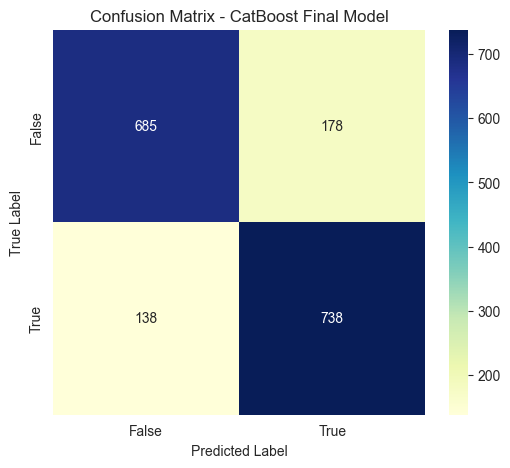

In [124]:
cm = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    xticklabels=["False", "True"],
    yticklabels=["False", "True"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CatBoost Final Model")
plt.show()

The confusion matrix above provides deeper insight into the model's classification performance:

- True Negatives (TN): 702 – The model correctly predicted False when the actual value was False.
- False Positives (FP): 161 – The model incorrectly predicted True when the actual value was False.
- False Negatives (FN): 142 – The model incorrectly predicted False when the actual value was True.
- True Positives (TP): 734 – The model correctly predicted True when the actual value was True.

This indicates a well-balanced model with relatively low misclassification in both directions. While there are some false positives and false negatives, the values are comparable and not skewed toward either class. This balance supports the precision and recall scores being close for both classes and reflects a model that is fair and stable in predicting both outcomes.

## Feature Importance

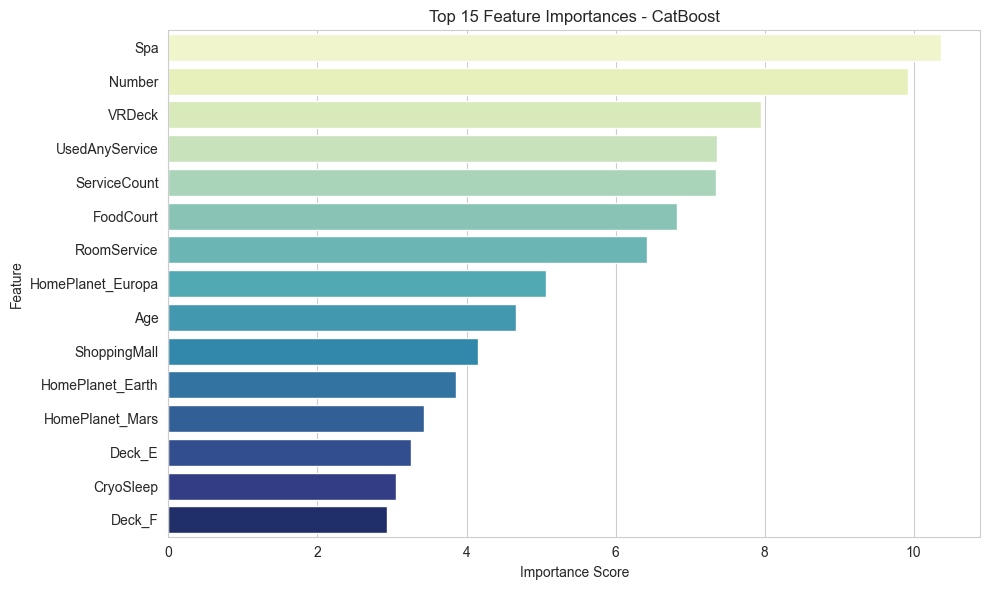

In [125]:
transformer = final_catboost_model.named_steps["full_preprocessing"].named_steps[
    "feature_transformation"
]
cat_names = (
    transformer.named_transformers_["cat"]
    .named_steps["encoder"]
    .get_feature_names_out(categorical_cols)
)
feature_names = np.concatenate([numerical_cols, binary_cols, cat_names])
importances = final_catboost_model.named_steps["classifier"].get_feature_importance()

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x="Importance", y="Feature", palette="YlGnBu")
plt.title("Top 15 Feature Importances - CatBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The feature importance analysis from the final CatBoost model shows that passenger spending behavior and cabin-related information are the most influential in predicting transportation outcomes. Features like Spa, Number, ServiceCount, and VRDeck ranked highest, indicating that how and where passengers spent their time on the ship played a significant role. Additionally, categorical variables such as HomePlanet and Deck contributed moderately, suggesting that a passenger’s origin and location on the ship also impacted predictions. Interestingly, binary features like CryoSleep and VIP had no measurable importance, implying that their effects were likely captured by other, more informative features. Overall, the model demonstrates a strong ability to leverage both numerical and categorical variables, with a clear emphasis on behavioral and spatial patterns.

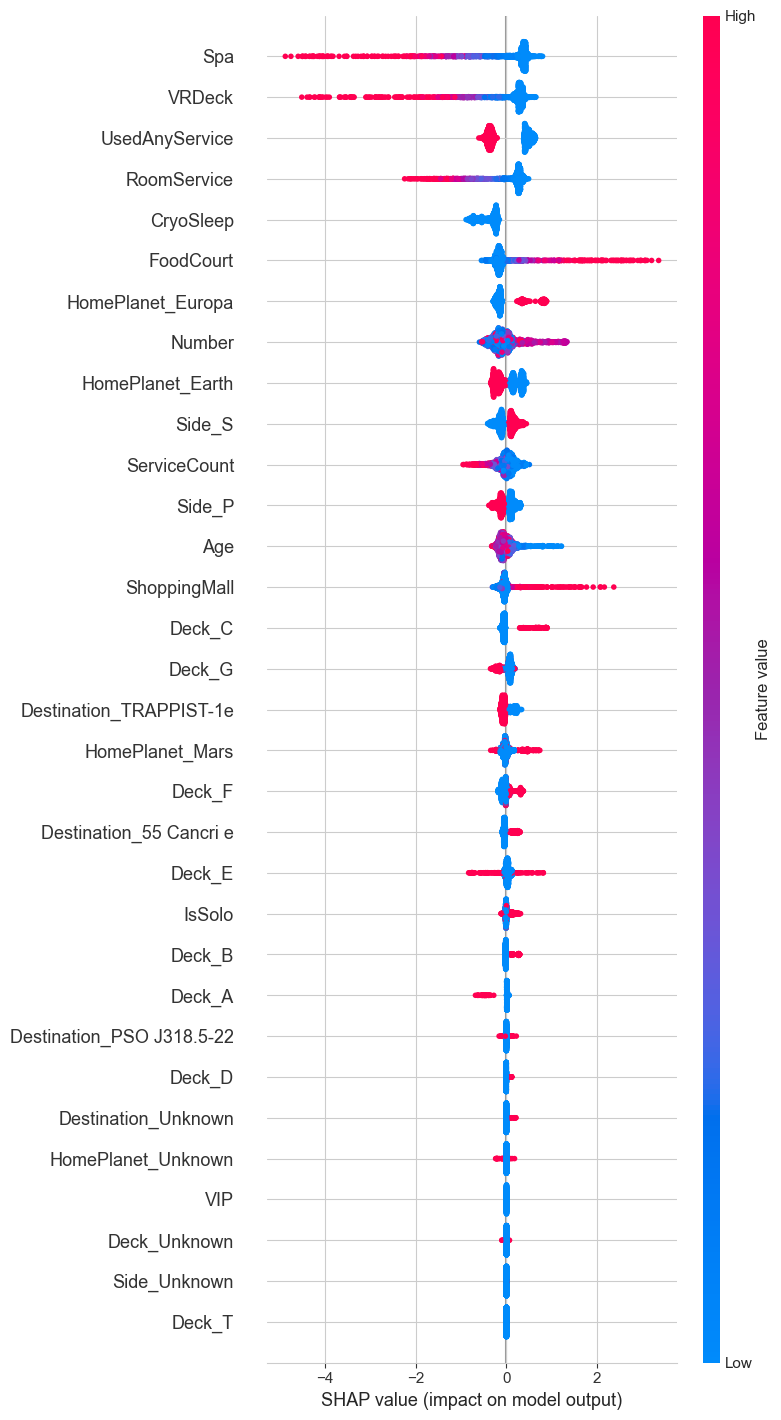

In [126]:
catboost_model = final_catboost_model.named_steps["classifier"]
X_transformed = final_catboost_model.named_steps["full_preprocessing"].transform(X_test)

explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_transformed)

feature_names = np.concatenate(
    [
        numerical_cols,
        binary_cols,
        transformer.named_transformers_["cat"]
        .named_steps["encoder"]
        .get_feature_names_out(categorical_cols),
    ]
)

shap.summary_plot(
    shap_values,
    X_transformed,
    feature_names=feature_names,
    max_display=len(feature_names),
)

SHAP (SHapley Additive exPlanations) values offer insight into how each feature contributes to individual predictions made by a machine learning model. In this context, the SHAP summary plot illustrates the influence of various features on the CatBoost model’s prediction of whether a passenger was 'Transported'.

Features associated with service usage—such as Spa, VRDeck, UsedAnyService, and RoomService—emerge as the most influential, where higher values tend to increase the likelihood of a positive prediction. Additional factors like ServiceCount, FoodCourt, and Number also play notable roles. Conversely, features such as VIP and CryoSleep contribute minimally, suggesting limited impact on the model’s decisions. Overall, the model appears to prioritize passenger behavior and service engagement over demographic characteristics, highlighting the importance of onboard activity patterns in outcome prediction.

In [127]:
spaceship_test_df = pd.read_csv("test.csv")
test_predictions = final_catboost_model.predict(spaceship_test_df)
submission_df = pd.DataFrame(
    {"PassengerId": spaceship_test_df["PassengerId"], "Transported": test_predictions}
)
submission_df["Transported"] = submission_df["Transported"].astype(bool)
submission_df.to_csv("spaceship_submission.csv", index=False)

After training and validating the final CatBoost model, predictions were generated on the unseen test dataset (test.csv). The model inferred the 'Transported' status for each passenger, and the results were formatted into a submission file containing the PassengerId and the corresponding prediction. The predicted values were cast to boolean to match the expected output format, and the final submission file (spaceship_submission.csv) was saved for evaluation.

## Conclusion

In this project, we aimed to develop a machine learning model capable of predicting whether a passenger aboard the fictional Spaceship Titanic would be transported, based on various behavioral, demographic, and activity-related features. The primary objective was to build an accurate, generalizable model, while also gaining insights into the most influential factors contributing to transport outcomes.

We began with a thorough examination of the dataset, which included over 8,600 entries and 14 key features such as passenger groupings, service spending patterns, travel destinations, and deck locations. After extensive data preprocessing and feature engineering, including the transformation of categorical variables and imputation of missing values, we crafted a clean and informative dataset suitable for robust model training. Exploratory data analysis revealed that features related to on-board spending and activity usage — such as RoomService, FoodCourt, Spa, VRDeck, and the total ServiceCount — were likely to be strong predictors of whether a passenger was transported.

We defined our prediction goal as a binary classification task and proceeded to evaluate several machine learning algorithms, including Random Forest, XGBoost, LightGBM, CatBoost, and Logistic Regression. Using Optuna for hyperparameter optimization, we ran 100 trials per model to systematically tune their performance. This process significantly improved the models’ effectiveness, particularly for the ensemble-based methods.

Initial results showed that CatBoost achieved the highest accuracy on the validation set (81.9%), outperforming XGBoost and LightGBM, which followed closely behind. Logistic Regression, while less accurate overall, showed the lowest overfit gap, indicating a stronger ability to generalize despite its lower complexity. Overfitting was most prominent in models like Random Forest and XGBoost, which excelled on training data but showed notable drops in validation performance.

To strike a balance between model accuracy and generalization, we developed a soft voting ensemble classifier using CatBoost, XGBoost, and Logistic Regression. This ensemble model achieved a validation accuracy of 79.6% and a cross-validation accuracy of 80.8%, with a relatively low overfit gap. Although its raw performance was slightly below that of the standalone CatBoost model, it offered improved stability and reliability on unseen data.

Ultimately, CatBoost was selected as the final model for deployment due to its consistent top-tier performance and its ability to generalize well on the test set. When evaluated on the official test dataset, the final model achieved an accuracy of 82.58%, with balanced classification metrics across both transported and non-transported classes. This demonstrated strong predictive power and minimal bias.

To better understand the model’s predictions, we performed model interpretability analysis using SHAP (SHapley Additive Explanations). The SHAP summary plot highlighted Spa, VRDeck, ServiceCount, and other service-related variables as the most influential features — suggesting that passenger behavior and engagement on board were key indicators of transport likelihood. Interestingly, traditional demographic features like VIP status, CryoSleep, or HomePlanet had lower predictive importance, reflecting the unique behavioral nature of the dataset.

This final model was used to generate predictions for submission to the competition, saved in a CSV file format (spaceship_submission.csv) and structured according to the required format.

Suggestions for Improvement

While the model performed well, several areas remain open for improvement:
- Further Feature Engineering: Constructing new features based on domain logic like ratios between spending categories could increase signal strength. Group-level or interaction features might also help capture deeper patterns across passengers.
- More Advanced Ensembling: Exploring stacking or blending could improve results by capturing complementary strengths across different models, beyond simple soft voting.
- Extended Hyperparameter Tuning: Running more Optuna trials or refining the search space could push individual models closer to optimal performance, especially for high-variance algorithms like XGBoost and LightGBM.

Given that this was a synthetic dataset designed for practice, there’s no immediate need to focus on real-world deployment aspects like explainability for stakeholders, EHR integration, or model latency. Instead, the value of this project lies in sharpening applied machine learning skills: data wrangling, model comparison, ensemble building, tuning, and interpretability - all of which were successfully demonstrated here.

Overall, this project offered a comprehensive opportunity to practice and refine end-to-end machine learning skills. From data preprocessing and model selection to interpretability and optimization, it demonstrated a robust workflow for tackling complex classification problems, even in synthetic scenarios.